# Coursework 2: Robotic behavioural cloning from images and actuator data

## Description
For this coursework, you are required to develop a behaviour cloning model. Behaviour cloning is a technique for training robotic agents using a dataset of sequences of actions. Consider the supervised learning definition where we have a dataset of observatios $d=\{(x_{1},y_{1}),...,(x_{n},y_{n})\}$ and the aim is to learn a function: $f:\mathcal{X}\rightarrow\mathcal{Y}$. In this case, $\mathcal{X}$ is the set of "observations" that the robot makes and $\mathcal{Y}$ is the set of actions that the robot takes.

The dataset you have been provided with contains examples of robot arms being required to pickup objects or drop objects (given it has already picked the object up) in a specific place. The observation space ($\mathcal{X}$) consists of:
- "front_cam_ob": A 3rd person image of the scene 
- "mount_cam_ob": An image of the scene taken from a camera mounted on top of the robotic arm, looking down
- "ee_cartesian_pos_ob": The positional and orientation co-ordinates of the robotic arm
- "ee_cartesian_vel_ob": The velocity of position and orientation of the robotic arm
- "joint_pos_ob": The position of the gripper which opens and closes

The action space ($\mathcal{Y}$) consists of:
- Three co-ordinates defining how much to move the robotic arm
- An action defining whether to open, not to move or close the gripper

The dataset is split into "trajectories" i.e., sequences of:
- $x_{i}$: The front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob, joint_pos_ob __at time point i__ 
- $y_{i}$: The action taken i.e., how to move the arm and the gripper __given the observations__ in $x_{i}$

More information on the dataset can be found at: https://github.com/clvrai/clvr_jaco_play_dataset?tab=readme-ov-file

### Task
Your task has been split into several questions, each exploring how to develop an appropriate model for learning $f:\mathcal{X}\rightarrow\mathcal{Y}$. The task will require you to:
- Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions: You will be required to evaluate a proposed deep learning architecture (which takes as input all of front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob and predict the two actions) and propose a new model which outperforms the existing model;
- Question 2: Define and evaluate a VAE model for performing self-supervised learning and tune it as best you can, to learn a latent representation that can be used as input to a downstream supervised model for behaviour cloning
- Question 3: Evaluate the performance of your model proposed in question 1 against your self-supervised VAE representations from question 2 (plus a supervised head) on the test set

### Pointers
Some helper functions have been provided for you including the following functionality:
- A training and validation loop capabale of:
  - Handling "half-precision" modelling;
  - Logging results to weights and biases;
- An eda template to help you visualise the data
- An evaluation template to help you load saved model checkpoints from weights and biases
- A preprocessing script to help you convert the data into train/validation and test splits;
  - In this preprocessing script, trajectories longer than 75 timesteps have been removed to ease the computational requirements of the task;
- A torch Dataset class capable of handling the multi-model nature of the data;
- A example collate_fn to use in Dataloaders

Additionally, it is strongly suggested to call ```torch.manual_seed(1)``` whenever you initialise your model (i.e., when you first create the model or call model.reset()). This will ensure the parameters are initialised at the same value each time.

### IMPORTANT
- You are __not__ allowed to use pre-trained models, developed outside of this coursework i.e., you could __not__ use a pre-trained YOLO model
- Questions have been marked under the title "Task", ensure that you answer/address all of the bullet points under these headings


## Data download
Download the data for the project from here: https://drive.usercontent.google.com/download?id=1tVSilmXhyQd8gxZAEhvKMnynw0qzRFSZ&authuser=0

Save the data locally at: ../data/all_play_data_diverse or in Google Collab at: /content/drive/MyDrive/comp0188_2425/cw2. Saving the data in these locations will ensure the proprocessing script provided runs correctly. If you would like to alter these locations, you can alter them in the config.py file of the provided comp0188_cw2 package via the ROOT_PATH global variable.

### transition_df.csv
You have additionally been provided with a csv called "transition_df.csv". This contains a row for each observation/action pair in the dataset and is used to generate the train/validation and test datasets for this task. Note that this csv contains all trajectories (even those over 75 timesteps). This csv might also be useful for EDA. The transition_df.csv should be placed in the same folder that you placed the raw data in (discussed above).

## Imports

The comp0188_cw2 contains some config functionality so that you can run the code in collab and locally (to test models)! When you first import the package, import the project_options and set the appropriate configs.
- project_options.collab = True will set the dataset directories for google collab whilst false will set suitable local directories
- project_options.debug = True will load a subset of data whilst False will load all of the data. 

__IMPORTANT__: Alterting these options __once you have loaded other functionality__ from comp0188_cw2 may result in unintended outcomes.

In [34]:
COLLAB = False
if COLLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install --force-reinstall git+https://github.com/joshuaspear/pymlrf.git
    !pip install wandb
    !pip install torchinfo
    !pip install jaxtyping
    !pip install git+https://github.com/joshuaspear/comp0188_cw2_public.git
    !pip install typeguard==2.13.3
else:
    !pip install --force-reinstall git+https://github.com/joshuaspear/pymlrf.git
    !pip install wandb
    !pip install torchinfo
    !pip install jaxtyping
    !pip install typeguard==2.13.3

^C
  Cloning https://github.com/joshuaspear/pymlrf.git to c:\users\lifeng\appdata\local\temp\pip-req-build-t3vrdmmp


  Running command git clone --filter=blob:none --quiet https://github.com/joshuaspear/pymlrf.git 'C:\Users\lifeng\AppData\Local\Temp\pip-req-build-t3vrdmmp'

  Resolved https://github.com/joshuaspear/pymlrf.git to commit 2e86313edd7900c1b5621b4e31368a36328b69f8


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pymlrf: filename=pymlrf-1.0.0-py3-none-any.whl size=20652 sha256=4c23e7eb036f0ded26b9a3b4ac8d39fe50d4689756dd7373d920529030741d5a
  Stored in directory: C:\Users\lifeng\AppData\Local\Temp\pip-ephem-wheel-cache-6458yg35\wheels\f1\cb\97\454b1a9071448b027d0faecba7b7e6ae819354c83df4e7e70e
Successfully built pymlrf
  Attempting uninstall: pymlrf
    Found existing installation: pymlrf 1.0.0
    Uninstalling pymlrf-1.0.0:
      Successfully uninstalled pymlrf-1.0.0


Ignore the error: 
```ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.```

In [1]:
COLLAB = False
!pip install -e comp0188_cw2_public-main/

Obtaining file:///D:/cloud/Projects/ucl/DLR/cw2/comp0188_cw2_public-main
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: comp0188_cw2
    Found existing installation: comp0188_cw2 1.0.0
    Uninstalling comp0188_cw2-1.0.0:
      Successfully uninstalled comp0188_cw2-1.0.0
  Running setup.py develop for comp0188_cw2


  DEPRECATION: Legacy editable install of comp0188_cw2==1.0.0 from file:///D:/cloud/Projects/ucl/DLR/cw2/comp0188_cw2_public-main (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457


In [2]:
from comp0188_cw2 import project_options
project_options.collab = COLLAB
print(project_options.collab)
project_options.debug = False
print(project_options.debug)

False
False


In [3]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import datetime
from pymlrf.Structs.torch import DatasetOutput
import copy

from comp0188_cw2.utils import load_all_files
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import datetime
from typing import List
from pymlrf.Structs.torch import DatasetOutput

from comp0188_cw2.config import (
    train_dh, val_dh, test_dh, WANDB_PROJECT
    )
from comp0188_cw2.models.CNNConfig import ConvolutionLayersConfig
from comp0188_cw2.models.base import BaseModel
from comp0188_cw2.models.JointCNNEncoder import JointCNNEncoder
from comp0188_cw2.models.CNN import CNN
from comp0188_cw2.models.MLP import MLP
from comp0188_cw2.Metric.WandBMetricOrchestrator import WandBMetricOrchestrator
from comp0188_cw2.Dataset.NpDictDataset import NpDictDataset
from comp0188_cw2.Loss.BalancedLoss import TrackerBalancedLoss
from comp0188_cw2 import logger
from comp0188_cw2.training.TrainingLoop import TorchTrainingLoop

2024-12-15 12:16:44,215 - pymlrf - WARNING - pymlrf environment variable not set. Logging to file will not be performed (__init__.py:47)


In [4]:
print(train_dh.loc)

D:/datasets/ucl/DLR_robot/train


## Build the dataset
You will only need to perform this step __once__ for the full dataset and __once__ for the debug dataset for the entire coursework, both locally and in Google collab. In Google Collab, the data will be saved in your Google Drive.

In [5]:
from comp0188_cw2.Preprocessing import main
RUN_PREPROCESSING = True
if RUN_PREPROCESSING:
  main()

(35722, 5)
Transitions excluded: 0.5418200474571924
25469
2901
7352
453
51
126


d:\cloud\projects\ucl\dlr\cw2\comp0188_cw2_public-main\src\comp0188_cw2\Preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tran_df_sub["is_test"] = np.where(
d:\cloud\projects\ucl\dlr\cw2\comp0188_cw2_public-main\src\comp0188_cw2\Preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tran_df_sub["is_val"] = np.where(
d:\cloud\projects\ucl\dlr\cw2\comp0188_cw2_public-main\src\comp0188_cw2\Preprocessing.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

## Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions

In [6]:
_keys = [
    "actions","front_cam_ob",
    "mount_cam_ob","terminals",
    "ee_cartesian_pos_ob",
    "ee_cartesian_vel_ob",
    "joint_pos_ob"
    ]
train_nps = load_all_files(train_dh.loc,"train_[0-9]+.h5",keys=_keys)
val_nps = load_all_files(val_dh.loc,"val_[0-9]+.h5",keys=_keys)

100%|██████████| 5/5 [00:00<00:00, 22.32it/s]


### Question 1.a Preprocessing
Most likely in machine learning pipelines, input data needs to be preprocessed before passing it to the model. This question requires you to specify the preprocessing that you will perform for the different types of data i.e., front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob. The dataset class provided in the associated "comp0188_cw2" package enables you to pass a dictionary of functions to preprocess each element of the observations and actions. The class expects a dictionary of transformations to apply to each input/output. 

#### Question 1.a.i Preprocessing steps (5 marks)

##### Task
- Complete the dictionaries below, specifying the type of transformations you wish to perform. For each element (of the observations and actions), you should __at least__ convert the output to a tensor thus, these transformations have been implemented for you. You may alter __any__ part of the code between the "INSERT YOUR CODE HERE" comments

In [7]:
# ******* INSERT YOUR CODE HERE *******
from typing import Literal
import h5py
import pandas as pd
import os
from comp0188_cw2.config import ROOT_PATH, FILE_PATH

def get_features_stats() -> dict:
    """
    Get the maximum, minimum, mean, std values for each feature in the dataset.
    """

    d = dict()
    keys = ["actions", "ee_cartesian_pos_ob", "ee_cartesian_vel_ob", "joint_pos_ob", "front_cam_ob", "mount_cam_ob"]

    for key in keys:
        if "cam_ob" in key:
            pixels = train_nps[key] / 255.0 # Normalise the pixels to be between 0 and 1
            pixels = pixels.reshape(-1).astype(np.float32) # Flatten the pixels and increase precision to float32 to avoid overflow

            d[key] = {
                "max": pixels.max(),
                "min": pixels.min(),
                "mean": pixels.mean(),
                "std": pixels.std()
            }

        else:
            d[key] = {
                "max": train_nps[key].max(axis=0),
                "min": train_nps[key].min(axis=0),
                "mean": train_nps[key].mean(axis=0),
                "std": train_nps[key].std(axis=0)
            }


    return d




def standardise_data(x: torch.Tensor, mean_and_std: dict, key: Literal["actions", "ee_cartesian_pos_ob", "ee_cartesian_vel_ob", "joint_pos_ob", "front_cam_ob", "mount_cam_ob"]) -> torch.Tensor:
    """
    Preprocess the data. Standardise the data to have a mean of 0 and a standard deviation of 1.

    Args:
        x (torch.Tensor): The data to be standardised.
        mean_and_std (dict): The mean and standard deviation values for each feature in the dataset. Key must be in mean_and_std.
        key (str): The key for the feature in mean_and_std.

    Returns:
        torch.Tensor: The standardised data.

    """

    mean_val = torch.tensor(mean_and_std[key]["mean"])
    std_val = torch.tensor(mean_and_std[key]["std"])
    x = (x - mean_val) / std_val

    return x

features_stats = get_features_stats()


global_transforms = {
    "front_cam_ob":
        transforms.Compose([
            transforms.ToTensor(),
            lambda x: x / 255.0,
            transforms.Normalize(mean=features_stats["front_cam_ob"]["mean"], std=features_stats["front_cam_ob"]["std"])
            ]),
    "mount_cam_ob": transforms.Compose([
            transforms.ToTensor(),
            lambda x: x / 255.0,
            transforms.Normalize(mean=features_stats["mount_cam_ob"]["mean"], std=features_stats["mount_cam_ob"]["std"])
            ]),
    "actions": lambda x: torch.tensor(x),
    "ee_cartesian_pos_ob": lambda x: standardise_data(torch.tensor(x), features_stats, "ee_cartesian_pos_ob"), # Standardise
    "ee_cartesian_vel_ob": lambda x: standardise_data(torch.tensor(x), features_stats, "ee_cartesian_vel_ob"), # Standardise
    "joint_pos_ob": lambda x: standardise_data(torch.tensor(x), features_stats, "joint_pos_ob") # Standardise
}
            
print(f"""

Actions:
    Max: {features_stats["actions"]["max"]}
    Min: {features_stats["actions"]["min"]}
    Mean: {features_stats["actions"]["mean"]}
    Std: {features_stats["actions"]["std"]}

EE Cartesian Pos Ob:
    Max: {features_stats["ee_cartesian_pos_ob"]["max"]}
    Min: {features_stats["ee_cartesian_pos_ob"]["min"]}
    Mean: {features_stats["ee_cartesian_pos_ob"]["mean"]}
    Std: {features_stats["ee_cartesian_pos_ob"]["std"]}

EE Cartesian Vel Ob:
    Max: {features_stats["ee_cartesian_vel_ob"]["max"]}
    Min: {features_stats["ee_cartesian_vel_ob"]["min"]}
    Mean: {features_stats["ee_cartesian_vel_ob"]["mean"]}
    Std: {features_stats["ee_cartesian_vel_ob"]["std"]}

Joint Pos Ob:
    Max: {features_stats["joint_pos_ob"]["max"]}
    Min: {features_stats["joint_pos_ob"]["min"]}
    Mean: {features_stats["joint_pos_ob"]["mean"]}
    Std: {features_stats["joint_pos_ob"]["std"]}

Front Cam Ob:
    Max: {features_stats["front_cam_ob"]["max"]}
    Min: {features_stats["front_cam_ob"]["min"]}
    Mean: {features_stats["front_cam_ob"]["mean"]}
    Std: {features_stats["front_cam_ob"]["std"]}

Mount Cam Ob:
    Max: {features_stats["mount_cam_ob"]["max"]}
    Min: {features_stats["mount_cam_ob"]["min"]}
    Mean: {features_stats["mount_cam_ob"]["mean"]}
    Std: {features_stats["mount_cam_ob"]["std"]}

""")

# ******* INSERT YOUR CODE HERE - END *******



Actions:
    Max: [0.2 0.2 0.2 2. ]
    Min: [-0.2 -0.2 -0.2  0. ]
    Mean: [-1.773e-03 -7.524e-04 -7.172e-03  1.008e+00]
    Std: [0.07086 0.07086 0.07086 0.567  ]

EE Cartesian Pos Ob:
    Max: [ 0.22    -0.2524   0.4014   0.03787  0.07275  0.998    0.1956 ]
    Min: [-0.4407  -0.6636   0.1569  -0.06793 -0.093    0.977    0.0474 ]
    Mean: [-0.0796   -0.428     0.2666    0.004375 -0.0159    0.991     0.1274  ]
    Std: [0.1007  0.1785  0.1012  0.00858 0.01575 0.2834  0.0501 ]

EE Cartesian Vel Ob:
    Max: [ 1.156   0.3928  0.404   3.352  12.25    5.16  ]
    Min: [ -1.153  -0.687  -0.458  -4.312 -11.88   -5.438]
    Mean: [-0.0006886 -0.002449  -0.00844    0.001617  -0.01225    0.003397 ]
    Std: [0.1028 0.0841 0.0983 0.1409 0.6157 0.2659]

Joint Pos Ob:
    Max: [1.412 1.38 ]
    Min: [-0.001232 -0.001232]
    Mean: [0.8843 0.8667]
    Std: [0.401 0.401]

Front Cam Ob:
    Max: 0.98193359375
    Min: 0.0011720657348632812
    Mean: 0.45064643025398254
    Std: 0.21882873773574

#### Question 1.a.ii Justification (5 marks)
##### Task
- In the markdown cell below, justify your decisions for preprocessing including where you have decided __not__ to apply preprocessing. You should include empirical evidence from your EDA analysis to support your decisions. Justfication __without__ evidence will be rewarded 0 marks.

##### Answer  
The data and plots used below are obtained through a separate *eda.ipynb*. Also, images for all cells in this notebook would be missing once it's no longer in the original folder. The PDF version helps providing the images instead.

**Temporal Analysis**  
Overall, there were no missing values or ragged arrays after examining the transition data frame and complete robot dataset, so there was no need for missing value analysis. However, it is important to note that episodes have different steps. The findings are as follows:

| Description                                | Value           |
|--------------------------------------------|-----------------|
| Shape of the entire robot dataset (time steps, features) | (77965, 5)     |
| Number of episodes                         | 1085            |
| Shape after applying a filter for episode length (≤ 75) | (35722, 5)     |
| Number of unique episodes after filtering  | 630             |
| Mean episode length                        | 59.23 ± 10.99   |
| Episode length range                       | (22, 74)        |
| Ragged arrays detected                     | No              |


**Actions**  
According to the [source](https://github.com/clvrai/clvr_jaco_play_dataset?tab=readme-ov-file) of the dataset, the first three values represent the desired changes in each component of the robot's effectors. These values are constrained between -0.2 and 0.2, which are the maximum values when at full potential.

![5 intermediate steps from episode 1 Front and Mounted camera](./img/e1-is.eda.png)

Take, for example, episode 1, which attempts a major displacement; even in this case, the delta remains constrained below 0.2. The intention of movement is depicted in the intermediate steps of episode 1 in the figure above, and the distribution of components is shown in the figure below.

![Actions Distributions for Episode 1](./img/e1-a.eda.png)

We also appreciate that the deltas are quite characteristic of each episode, meaning that although they exhibit a very irregular shape, we should not treat them as outliers or discard them.

Since actions serve as the label and the range of values is adequate, no preprocessing is necessary.

Furthermore, it is worth noting that the fourth component, which is categorical, is already label encoded. This is acceptable because one-hot encoding is applied before introducing the data to the model in future steps.

All numerical features (as opposed to images) need to be converted to float32 manually to ensure consistency with image tensor transformation.

Finally, this is the distribution of the actions target variable. Despite its tri-modal appearance, mostly at the minimum, middle, and maximum values, this characteristic reflects prevalent robot movements, so we can leave it unchanged.

![Actions Distribution](./img/actions_distribution.eda.png)

**front_cam_ob**  
The images are square with a height and width of 224 pixels and have 3 channels. One episode typically consists of a single movement, such as picking up an item (episode 517 below), moving a held item to another location (episode 1 above), setting an item down (episode 781 below), etc.

The images were taken with large granularity, indicating little difference between adjacent pictures. This is consistent with the 10Hz frequency of collection described in the dataset.

![5 intermediate steps from episode 514 Front and Mounted camera](./img/e514-is.eda.png)
![5 intermediate steps from episode 781 Front and Mounted camera](./img/e781-is.eda.png)

The images are consistent in shape, so there's no need to handle ragged arrays. The preprocessing script in the library automatically converts images to grayscale, so there is no need to perform this transformation.

Note that data augmentation methods such as shifting and rotation are not suitable here, as the movements are not space invariant. The location and posture matter, so we should not perform such augmentations. However, adjusting brightness or contrast (in gray space) could be allowed if needed, as long as the essential spatial information is preserved.

We first apply min-max scaling to (0, 1) to standardize pixel values within this range. Then, standardisation with a mean of 0 and a standard deviation of 1 can stabilize the training process and help centralize values around 0. This is achieved by first dividing by 255.0, the maximum pixel value, and then applying standardisation using $x = (x - global\_mean) / global\_std$. The mean, standard deviation, maximum, and minimum of each feature are as follows:

Actions

| Statistic | Values                        |
|-----------|-------------------------------|
| Max       | [0.2, 0.2, 0.2, 2.0]          |
| Min       | [-0.2, -0.2, -0.2, 0.0]       |
| Mean      | [-1.773e-03, -7.524e-04, -7.172e-03, 1.008e+00] |
| Std       | [0.07086, 0.07086, 0.07086, 0.567] |

EE Cartesian Pos Ob

| Statistic | Values                                                                |
|-----------|-----------------------------------------------------------------------|
| Max       | [0.22, -0.2524, 0.4014, 0.03787, 0.07275, 0.998, 0.1956]              |
| Min       | [-0.4407, -0.6636, 0.1569, -0.06793, -0.093, 0.977, 0.0474]           |
| Mean      | [-0.0796, -0.428, 0.2666, 0.004375, -0.0159, 0.991, 0.1274]           |
| Std       | [0.1007, 0.1785, 0.1012, 0.00858, 0.01575, 0.2834, 0.0501]            |

EE Cartesian Vel Ob

| Statistic | Values                                                     |
|-----------|------------------------------------------------------------|
| Max       | [1.156, 0.3928, 0.404, 3.352, 12.25, 5.16]                 |
| Min       | [-1.153, -0.687, -0.458, -4.312, -11.88, -5.438]           |
| Mean      | [-0.0006886, -0.002449, -0.00844, 0.001617, -0.01225, 0.003397] |
| Std       | [0.1028, 0.0841, 0.0983, 0.1409, 0.6157, 0.2659]           |


Joint Pos Ob

| Statistic | Values              |
|-----------|---------------------|
| Max       | [1.412, 1.38]       |
| Min       | [-0.001232, -0.001232] |
| Mean      | [0.8843, 0.8667]    |
| Std       | [0.401, 0.401]      |


Front Cam Ob

| Statistic | Value               |
|-----------|---------------------|
| Max       | 0.98193359375       |
| Min       | 0.0011720657348632812 |
| Mean      | 0.45064643025398254 |
| Std       | 0.2188287377357483  |


Mount Cam Ob

| Statistic | Value               |
|-----------|---------------------|
| Max       | 0.9990234375        |
| Min       | 0.004604339599609375 |
| Mean      | 0.4942496716976166  |
| Std       | 0.1970803290605545  |


**mount_cam_ob**  
Mounted camera observations share the same format and status as the front camera observation. The view of the scene is from above, and therefore, the few objects in the image are usually those important to the action being performed.

The front and mounted cameras exhibit slightly different color spaces. For example, the color of an orange stand in the front camera appears more yellowish in the mounted camera (episode 1 figure).

The same rules of data augmentation and standardisation apply to mounted camera observations.

**ee_cartesian_pos_ob**  
These observations contain the position and orientation components of the end effector in space. Taking as an example episode 1's End Effector Position Distribution figure, we also observe irregular and characteristic distributions for this displacement. For instance, the position components have low variability, which means the same position is maintained for long time steps. Therefore, we shouldn't consider any outlier handling here either.

![End Effector Position Distributions for Episode 1](./img/e1-eep.eda.png)

Similarly, these position and orientation components should be standardised to have a mean of 0 and a standard deviation of 1. They largely demonstrate a normal distribution, which is suitable for standardisation, as shown in the distributions below from the entire training set.

![End Effector Position Distributions](./img/ee_pos_distribution.eda.png)

**ee_cartesian_vel_ob**  
The same analysis can be applied to the velocity components. In this case, velocity is described in three translational and three rotational axes. Using episode 1 as an example again, below is the End Effector Velocity Distribution.

![End Effector Velocity Distributions for Episode 1](./img/e1-eev.eda.png)

We observe that episode 1 involves largely horizontal plane displacements, resulting in significant variation in the X and Y axes. In contrast, the Z axis, representing height, is mostly centered around 0 because the height is largely maintained during such displacements.

In a similar vein, these position and orientation components should be standardised to have a mean of 0 and a standard deviation of 1. In the figure below, we barely see the histogram distribution due to outliers squeezing the feature range into the middle. Standardisation can mitigate this by centering data around 0.

![End Effector Velocity Distributions](./img/vel_distribution.eda.png)

**joint_pos_ob**  
![Joint Position Distributions for Episode 1](./img/e1-jp.eda.png)

Most of the joint position information is not useful, as stated in the [source](https://github.com/clvrai/clvr_jaco_play_dataset?tab=readme-ov-file). This is likely because the position of other joints is somewhat encoded in the positional and velocity components previously examined. Therefore, we focus on examining the last two components of episode 1 Joint Position Distribution figure. Preprocessing has already filtered out the first six components.

We observe that the position distribution is almost degenerate, as the joint positions of the arm remain unchanged. In another example, like episode 781 below, we see some degree of variation, which is more typical.

In this case, we should follow the guidance from the dataset and use only the last two data features. This has already been implemented in the preprocessing. Additionally, standardisation to mean 0 and standard deviation 1 should be applied as default, bringing the values into a range that supports smoother convergence.

![Joint Position Distributions for Episode 781](./img/e781-jp.eda.png)

![Joint Position Distributions](./img/joint_pos_distribution.eda.png)

### Question 1.b End-to-end supervised model evaluation
The code below defines an end to end supervised model which: 
- Jointly encodes the two images ("front_cam_ob", "mount_cam_ob") using a CNN architecture (image_encoder);
- Seperately encoding the positional and velocity observations using an MLP;
- Combines the two embeddings by adding them together and;
- Passes the combined embedding into a final MLP layer (dense)
  
This question requires you to define sutable loss functions for the model and then evaluate the performance.

In [8]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]
    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

#### Question 1.b.i Loss definitions (3 marks)
For the model defined above, the proposed loss function is defined where the contribution of "pos_criterion" and "grp_criterion" are equally weighted and the mean of the two values loss are used to define the final loss. Furthermore, the loss for the positional actions is the MSE and the loss for grp_criterion is the CrossEntropyLoss.

##### Task:
- Justify why this composite loss function is reasonable. You should make reference to the range of values predicted by the deep learning model.

##### Answer 
The proposed composite loss function is reasonable because it aligns with the nature of the predicted values and the type of tasks the model is performing. According to our EDA and the source dataset documentation, the first three elements of the target variable (representing position) are continuous and take floating-point values between range (-0.2 and 0.2). In contrast, the last element (representing the gripper state) is categorical and consists of discrete values from set {0, 1, 2}.

Therefore, using Mean Squared Error (MSE) Loss is appropriate for predicting continuous positional actions, facilitating regression tasks by minimising the variance between predicted and actual positions. Meanwhile, Cross Entropy Loss is appropriate for the categorical gripper state, as it quantifies the discrepancy between the model's classification predictions and the true categories. By equally weighting these two loss components, we ensure that both regression and classification tasks are considered equally important in the final optimisation objective.

In [9]:
pos_criterion = nn.MSELoss(reduction="mean")
grp_criterion = nn.CrossEntropyLoss(reduction="mean")

In [10]:
torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "half_precision": False,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print("Number of batches: ", len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print("Input Images batch shape: ", input_dim)
input_dim = first_batch.input["obs"].shape
print("Input Observation batch shape: ", input_dim)
pos_dim = first_batch.output["pos"].shape
print("Output Position batch shape: ", pos_dim)
grp_dim = first_batch.output["grp"].shape
print("Output Gripper batch shape: ", grp_dim)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()
optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print("Sample loss: ", __criterion(res,first_batch.output))


Number of batches:  25469
Input Images batch shape:  torch.Size([64, 2, 224, 224])
Input Observation batch shape:  torch.Size([64, 15])
Output Position batch shape:  torch.Size([64, 3])
Output Gripper batch shape:  torch.Size([64, 3])
Sample loss:  tensor(1.7589, device='cuda:0')


*Quick note on shapes* 

At debug=False mode:
```
Number of batches:  25469
Input Images batch shape:  torch.Size([64, 2, 224, 224])
Input Observation batch shape:  torch.Size([64, 15])
Output Position batch shape:  torch.Size([64, 3])
Output Gripper batch shape:  torch.Size([64, 3])
```

At debug=True mode:
```
Number of batches:  1274
Input Images batch shape:  torch.Size([4, 2, 224, 224])
Input Observation batch shape:  torch.Size([4, 15])
Output Position batch shape:  torch.Size([4, 3])
Output Gripper batch shape:  torch.Size([4, 3])
```

In [ ]:
mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

output_dir = "./preds/baseline/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
sl_trainer = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    preds_save_type="csv", # Save predictions
    output_dir=output_dir
)


wandb_name = "End_to_end_1"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"


orig = datetime.datetime.now()
###
# !!!!!
# If the below function pops error, it is because TrainSingleEpoch and ValidateSingleEpoch from comp0188_cw2.training needs a small modification.
# Change the lines "losses = torch.tensor(0)" to "losses = torch.tensor(0).float()" is enough.
# Since this is a small fix, changing the code directly in the library is preferred over creating a new version of the library and publish it.
# !!!!!
###
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    },
    )
post_train = datetime.datetime.now()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lifeng-qiu-lin (lifeng-qiu-lin-ucl). Use `wandb login --relogin` to force relogin


100%|██████████| 398/398 [00:35<00:00, 11.27it/s]


epoch_train_loss,█▁▁▁▁▁▁▁▁▁
epoch_val_loss,▂▁▁▁▂▂▄▆██
grp_train_loss,█▄▄▄▅▃▃▃▃▂▂▂▂▂▂▁▂▂▂▂▁▃▁▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂
grp_val_loss,▃▂▂▄▃▄▁▄▄▄▂▂▂▂▅▁▁▂▄▃▂▄▅▃▃▁▂▅▃▂▃▅█▂▄▃▆▅▂▁
pos_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pos_val_loss,▂▂▅▅▂▅▄▆▁▂▂▂▂▃█▅▅▃▃▂▂▅▃▂▃▆▂▂▄▂▂▂▁▃▂▁▃▂▂▁
epoch_train_loss,0.12649
epoch_val_loss,1.1356
grp_train_loss,0.08278
grp_val_loss,0.67233
pos_train_loss,0.00254


#### Question 1.b.ii Model evaluation (marks broken down in sub questions)
This question requires you to evaluate the perfomance of the model defined above by interpreting model training/validation metrics and investigating the specific failure modes of the model. Run the cells above which will train the model for 10 epochs. 

**IMPORTANT, for questions (1.b.ii.i, 1.b.ii.ii, 1.b.ii.ii)** 
- You are **not** expected to train a baseline model and you will be awarded **0 marks** for training such a model and evaluating performance against it. 
- Furthermore, when interpretting the metric(s) and justifying your conclusions, you will loose marks for failing to comment on striking results that are obvious to the marker.
- **Incorrect interpretations of metrics** will be **negatively penalised**
- Finally, where you have been asked for empirical evidence, but provide none, you will be awarded __0 marks__.

#### Question 1.b.ii.i Epoch selection (3 marks)
##### Task
- Select an appropriate epoch using a suitable method, provide __empirical evidence__ for your choice.

##### Answer

To select the most appropriate epoch for model evaluation, we plotted both the training and validation loss across epochs. In the figure below, the training and validation losses are depicted on a single axis:

![Baseline - epoch losses](./img/baseline.epoch_losses.png)

However, it is challenging to identify the epoch with the lowest validation loss from this figure, and this is crucial as we seek the epoch with the best out-of-sample performance. Thus, we specifically plotted the validation loss per epoch:

![Baseline - epoch validation loss](./img/baseline.epoch_val_loss.png)

From this plot, it is apparent that the minimum validation loss occurs at epoch 3. This suggests that epoch 3 achieves the best generalisation to the validation set and thus represents the optimal point for evaluation. Consequently, epoch 3 is selected as the preferred epoch for assessing the model's performance.

#### Question 1.b.ii.ii Performance evaluation (8 marks)
##### Task
- Draw conclusions regarding how well the model performs. To do this you may want to use additional metrics to the one(s) already reported. Critically, you should __contextualise__ the performance of the model. We are expecting discussion points a long the lines: _The model achieved a score of X according to metric Y. This suggests that the model is/is not performing well, because..._

##### Answer

**Loss Decomposition**

Focusing on epoch 3, we obtained the following validation loss from WandB:

| Metric     | Value   |
|------------|---------|
| Total Loss | 0.58092 |


Further analysis using a separate *eval.ipynb* revealed the loss breakdown from epoch 3 predictions on the validation set:

| Metric                  | Value  |
|-------------------------|--------|
| Gripper Cross-Entropy Loss | 0.5737 |
| Position MSE Loss          | 0.0052 |


Note: Minor variations may occur due to numerical operations across different environments.

**Gripper Evaluation**

While losses cannot be directly compared due to differing scales, it's evident that the majority of the loss originates from the gripper's cross-entropy. This indicates that while the model performs well in predicting position, its performance in determining the gripper state is comparatively weaker.

To gauge its performance intuitively, we calculated the gripper's prediction accuracy. This involved extracting logits from the final layer, then determining classes by selecting the index of the largest value, and comparing them with the actual validation dataset. The results are as follows:

| Metric                   | Value  |
|--------------------------|--------|
| Gripper Accuracy         | 0.7680 |
| Gripper Weighted F1 Score | 0.7447 |

We opted for the weighted F1 Score, rather than macro or micro scores, due to its ability to provide a balanced perspective across both majority and minority classes, accounting for their natural prevalence.

At first glance, one might consider a 76.8% accuracy and a similar F1 score satisfactory. However, when compared to a baseline chance model always predicting the majority class (i.e., not moving the gripper):

| Metric                              | Value  |
|-------------------------------------|--------|
| Gripper Chance Accuracy             | 0.7449 |
| Gripper Chance Weighted F1 Score    | 0.6360 |


It becomes apparent that the model's high accuracy primarily stems from predicting the majority class, as illustrated below:

![End to End Model vs Chance Gripper Performance](./img/gripper_vs_chance.performance.png)

Despite this, the model isn't entirely flawed due to its overstated accuracy in an imbalanced dataset context. It improves the F1 Score from 0.6360 to 0.7447, demonstrating some degree of learning regarding gripper operations, surpassing a naive strategy of keeping the gripper stationary. While improvements are possible, this reflects a tangible level of learning.

**Position Evaluation**  

Regarding position loss, we assess it using RMSE (Root Mean Square Error), representing errors in units akin to the action position delta. Given the known movement range of 0.4, we normalise RMSE to derive the Relative Position Error (this is not Means Absolute Percentage Error but Normalised RMSE, error magnitude relative to the variability of data), which gauges the model's predicted position quality relative to the true position:

| Metric                    | Value  |
|---------------------------|--------|
| Position Model MSE        | 0.0052 |
| Position Model RMSE       | 0.0723 |
| Relative Position Error   | 0.1809 |

Chance Model:
| Metric                    | Value  |
|---------------------------|--------|
| Position Chance MSE       | 0.0117 |
| Position Chance RMSE      | 0.1083 |
| Relative Position Error   | 0.2710 |



Visual representation:

![End to End Model vs Chance Position Performance](./img/position_vs_chance.performance.png)

While not optimal, the model demonstrates a reasonable ability to predict positions, with a 0.0723 RMSE and an 18.09% Relative Position Error, compared to the chance model's 0.1083 RMSE and 27.10% error rate. This indicates the model's potential in localising positions, albeit with an average error margin of 18%.

#### Question 1.b.ii.iii Model failure modes (9 marks)
##### Task
- Investigate the failure modes of the model. You should: 
  - Demonstrate the failure mode using **empirical evidence** e.g., _the model fails on X observations as demonstrated by..._
  - Assess the impact of these failure modes using **empirical evidence** i.e., how significant is this problem. You should consider both metrics and dataset coverage
  - Conclude __why__ the model might be failing on these observations **empirical evidence** e.g., _X part of the model performs poorly, as demonstrated by..._

__IMPORTANT__:
- Marks will be penalised if the failure modes you identify are not systematic i.e., you select a single observation that the model fails on. If you cannot identify any general failure modes of the model, you will be awarded full marks if you provide empirical evidence justifying why there are no systematic failure modes which sufficienty accounts for the diversity of observations in the dataset.


##### Answer

From the results and insights logged in WandB, combined with the evaluation analysis, we identify several failure modes in the baseline model.

**Overfitting**

A prominent failure mode is early overfitting observed in the model. This is illustrated in the plot below:

![Baseline - epoch losses](./img/baseline.epoch_losses.png)

The model's training loss decreases rapidly during the initial epochs, whereas the validation loss decreases only slightly at first and then plateaus. This discrepancy indicates a generalisability issue, where the model struggles to extend its learning from the training set to the validation set. Such a phenomenon highlights a critical challenge in tuning the model to bridge the distribution gap from known to unknown data.

**Outstanding Gripper Loss from Decomposition**

We further examine how the gripper and position losses evolve over the epochs by plotting their respective train and validation losses, which are logged as individual components. Below are the initial visualisations:

![Baseline - Position Losses](./img/baseline.position_losses.png)

![Baseline - Gripper Losses](./img/baseline.gripper_losses.png)

These graphs may appear erratic due to variations in batch-level logging, causing noticeable oscillations. The straight lines in validation loss represent training steps without validation.

To clarify, we extract validation losses, applying a smoothing function with a running average in WandB at 45 iterations, approximating the number of validation batches:

![Baseline - Position Validation Loss Smoothed](./img/baseline.position_val_loss_smoothen.png)

![Baseline - Gripper Validation Loss Smoothed](./img/baseline.gripper_val_loss_smoothen.png)

Notably, the validation loss for position generally trends downward and plateaus in later epochs, suggesting learning stability. Conversely, the gripper loss increases over time, indicating difficulties in learning gripper states.

**Loss Magnitude**

Furthermore, the cross-entropy loss magnitude tends to overshadow the position's MSE Loss. Consider the following points:
1. The aggregate loss is primarily influenced by gripper performance, possibly obscuring position evaluation.
2. The model's primary challenge appears to be improving gripper performance, if we want to decrease the proposed loss.

This disparity is reflected in the overall validation loss, which increases relatively quickly compared to other metrics. Gripper performance's primary contribution to this trend is evident.

Additionally, the large fluctuations between validation batches suggest prediction instability, performing well at times but not consistently. This volatility, particularly in gripper loss over epochs, may confound interpretations of model performance.

Future adjustments should aim for losses with comparable magnitudes to important predictive contributions. Given the robotic context, gripper performance may, in fact, deserve significant weight to avoid consequential errors like item drops during transport.

**Gripper State Analysis**

Delving deeper, we analyse the challenges in gripper predictions using a confusion matrix:

![End to End Model Gripper Confusion Matrix](./img/baseline.gripper_confusion_matrix.png)

The correct predictions for open and close states are considerably low, with a strong bias toward predicting the maintain state. This tendency is likely due to the prevalence of the maintain state in the dataset, indicating the model's struggle in discerning when to open and close the gripper.

Further insights from the classification report below reveal:

| Class        | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| Open         | 0.35      | 0.23   | 0.27     | 373     |
| Maintain     | 0.83      | 0.93   | 0.88     | 2161    |
| Close        | 0.55      | 0.36   | 0.44     | 367     |
| **Accuracy** |           |        | 0.77     | 2901    |
| **Macro Avg**| 0.58      | 0.51   | 0.53     | 2901    |
| **Weighted Avg** | 0.73  | 0.77   | 0.74     | 2901    |

The notably low recall for open and close states, particularly open, implies the robot arm frequently fails to open the gripper when necessary. Given the importance of grasping and moving objects in robotic tasks, the current model does not perform satisfactorily in this critical aspect.

### Question 1.c Model tuning
Now you have evaluated the proposed model, you are required to iterate and train a higher performing one. You are expected to run experiments that help you understand where the model is underperforming, guiding your development.

#### Question 1.c.i Model tuning (5 marks)
##### Task
- Using the code blocks below, implement a model which improves over the previous. Improve the performance as best you can and report the results using the metric/metrics you used in question 1.b.ii Model evaluation. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [ ]:
# ******* INSERT YOUR CODE HERE *******
def get_dataset(train: bool, transforms: dict) -> NpDictDataset:
    """
    Get the dataset.

    Args:
        train (bool): Whether to get the training dataset.
        transforms (dict): The transforms dictionary.

    Returns:
        NpDictDataset: The dataset.

    """

    if train:
        dataset = NpDictDataset(
            array_dict={k: train_nps[k].astype(np.float32) for k in train_nps},
            transform_lkp=transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
            target_offset=exp_kwargs["target_offset"]
        )

    else:
        dataset = NpDictDataset(
            array_dict={k: val_nps[k].astype(np.float32) for k in val_nps},
            transform_lkp=transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
            target_offset=exp_kwargs["target_offset"]
        )

    return dataset

def get_dataloader(dataset: NpDictDataset, shuffle: bool, batch_size: int) -> DataLoader:
    """
    Get the dataloader.

    Args:
        dataset (NpDictDataset): The dataset.
        shuffle (bool): Whether to shuffle the dataset.
        batch_size (int): The batch size.

    Returns:
        DataLoader: The dataloader.

    """

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_func,
    )

def create_image_encoder(activation: nn.Module, dropout: float) -> JointCNNEncoder:
    return JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128,
        actvton=activation,
        dropouts=[dropout]
        )
)

def create_obs_encoder(activation: nn.Module, dropout: float) -> MLP:
    return MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128,
    actvton=activation,
    dropouts=[dropout, dropout]
)

def create_dense(activation: nn.Module, dropout: float) -> MLP:
    return MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6,
    actvton=activation,
    dropouts=[dropout, 0]
)

wandb_name = "End_to_end.Tuned"
wandb_grp="End_to_end"

exp_kwargs = {
    "target_offset": 0,
    "half_precision": False,
    "batch_size": 64,
    "learning_rate": 0.0001,
    "preprocessing": "Standardisation",
    "architecture": "Improved",
    "activation": "ReLU",
    "dropout": 0.4
}

actvton = nn.ReLU() if exp_kwargs["activation"] == "ReLU" else nn.LeakyReLU()
dropout_rate = exp_kwargs["dropout"]
    
torch.manual_seed(1)
model = Baseline1(
    image_encoder=create_image_encoder(actvton, dropout_rate),
    obs_encoder=create_obs_encoder(actvton, dropout_rate),
    dense=create_dense(actvton, dropout_rate)
)
model = model.cuda()

optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
)

scheduler = None

exp_kwargs["optimiser"] = optimizer.__class__.__name__
exp_kwargs["scheduler"] = scheduler.__class__.__name__ if scheduler is not None else None
exp_kwargs["model_def"] = model.__repr__()

model.reset({},{},{})

mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
)

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
)

train_dataset = get_dataset(train=True, transforms=global_transforms)
val_dataset = get_dataset(train=False, transforms=global_transforms)

train_dataloader = get_dataloader(train_dataset, shuffle=True, batch_size=exp_kwargs["batch_size"])
val_dataloader = get_dataloader(val_dataset, shuffle=False, batch_size=exp_kwargs["batch_size"])

output_dir = "./preds/e2e_tuned/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
sl_trainer = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    scheduler=scheduler,
    preds_save_type="csv",
    output_dir=output_dir
)

orig = datetime.datetime.now()

sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    },
    )
post_train = datetime.datetime.now()

# ******* INSERT YOUR CODE HERE - END *******

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lifeng-qiu-lin (lifeng-qiu-lin-ucl). Use `wandb login --relogin` to force relogin


100%|██████████| 398/398 [00:39<00:00, 10.06it/s]


epoch_train_loss,█▆▅▄▃▃▂▂▁▁
epoch_val_loss,█▄▃▂▁▁▁▄▅▅
grp_train_loss,█▅▅▆▄▅▃▆▃▃▄▂▂▃▄▃▂▃▄▃▅▃▄▃▃▃▂▃▁▂▂▃▂▁▂▁▁▁▁▁
grp_val_loss,▅▇▇▅▃▄▆▇▃▃▃▇▄▂▃▄▄▃▃▄▃▁▁▁▅▁▃▂█▅▃▁▄▂▁▂▇▁▂▃
min_train_loss,█▆▅▄▃▃▂▂▁▁
min_val_loss,█▄▃▂▁▁▁▁▁▁
pos_train_loss,▆██▅▄▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
pos_val_loss,█▄▃▄▂▃▂▇▃▄▄▄▃▁▂▄▃▃▁▃▃▆▃▃▅▄▂▃▁▂▃▅▄▃▃▂▃▂▃▂
epoch_train_loss,0.13532
epoch_val_loss,0.44109
grp_train_loss,0.10113


##### Answer

Results are as follows:

![End to end Tuned - Epoch Losses](./img/e2e_tuned.epoch_losses.png)

The tuned model achieves its lowest validation loss of 0.34522 at epoch 5.

| Model                    | Validation Loss |
|--------------------------|-----------------|
| Tuned End-to-End Model   | 0.34522         |
| Baseline End-to-End Model | 0.58092         |

The improvement over the baseline model, which had a validation loss of 0.58092, is significant.

![Baseline vs Tuned - Epoch Losses](./img/baseline_e2e_tuned.losses.png)

Upon tuning, the decomposed losses evolved as follows:

| Metric                  | Baseline | Tuned |
|-------------------------|----------|-------|
| Gripper Cross-Entropy Loss | 0.5737   | 0.3421 |
| Position MSE Loss       | 0.0052   | 0.0077 |

We observe an increase in performance for gripper status prediction, though at the expense of a slight decrease in position prediction accuracy, reflecting our focus on enhancing gripper performance as previously indicated.

Position Losses:

| Position Loss Metric     | Chance  | Baseline | Tuned  |
|--------------------------|---------|----------|--------|
| MSE                      | 0.0117  | 0.0052   | 0.0077 |
| RMSE                     | 0.1083  | 0.0723   | 0.0878 |
| Relative Position Error  | 0.2710  | 0.1809   | 0.2194 |

Gripper Losses:

| Gripper Loss Metric     | Chance  | Baseline | Tuned  |
|-------------------------|---------|----------|--------|
| Accuracy                | 0.7449  | 0.7680   | 0.8635 |
| Weighted F1 Score       | 0.6360  | 0.7447   | 0.8615 |

The following plots visualise the trade-off: while position loss is slightly higher than in the baseline, gripper loss decreases significantly with less tendency to increase.

![Baseline vs Tuned - Position Losses](./img/baseline_e2e_tuned.position_val_loss_smoothen.png)
![Baseline vs Tuned - Gripper Losses](./img/baseline_e2e_tuned.gripper_val_loss_smoothen.png)

The classification report and confusion matrix for the tuned model are as follows:

| Class        | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| Open         | 0.56      | 0.65   | 0.60     | 373     |
| Maintain     | 0.96      | 0.97   | 0.96     | 2161    |
| Close        | 0.61      | 0.47   | 0.53     | 367     |
| **Accuracy** |           |        | 0.86     | 2901    |
| **Macro Avg**| 0.71      | 0.70   | 0.70     | 2901    |
| **Weighted Avg** | 0.86  | 0.86   | 0.86     | 2901    |

Remarkably, there is a substantial increase in recall for open and close states, critical tasks that the robot arm needs to master. The maintain state also sees improved precision, a key factor given its majority presence in the dataset.

| Metric                  | Open | Close | Maintain |
|-------------------------|------|-------|----------|
| Baseline Recall         | 0.23 | 0.36  | 0.93     |
| Tuned Recall            | 0.65 | 0.47  | 0.97     |

![End to End Tuned Gripper Confusion Matrix](./img/tuned.gripper_confusion_matrix.png)

In the confusion matrix, it's apparent that the numbers along the diagonal have increased, indicating enhanced prediction accuracy. Specifically, for the open state, the tuned model nearly tripled its true positives. There's also an increase in the opposing diagonal, suggesting that while the model can now better differentiate between maintaining or performing an action, it still exhibits some uncertainty selecting between opening or closing.

#### Question 1.c.ii Discussion (marks broken down in subsections below)

##### Task
In the markdown blocks below, discuss **three** experiments that you ran during the development of your model, defined in 1.c.i Model tuning which were the **most insightful** with respect to the design of your final model. Importantly, **most insightful** needn't necessarily be the final decisions that appear in the model defined in question 1.c.i Model tuning, rather they should be experiments that most shaped your model development process. For example: 
- You might decide to use a learning rate scheduler and decrease the learning rate at epoch 10 (call this experiment "EXP_LR");
- This experiment produces a jump in performance and unlocks a series of further fruitful experiments into learning rate scheduling;
- However, in the model reported in question 1.c.i Model tuning, you use a learning rate schedule with descreases at epochs 6 and 15 (since these produced a marginal performance over "EXP_LR")
- For this question __you should discuss EXP_LR__.
  
For each experiment, complete the "Description", "Result" and "Conclusion" sections where the following information should be provided:
* __Description__: What delta were you measuring i.e., change of architecture, change of learning rate etc?
* __Justification__: **Why** are you conducting the experiment?
  * What was the context of the model development process up to this point? What did you already know about how well the model performed/why it was performing/what were the challenging data points?
* __Conclusion__: What did you __learn__ from the experiment and provide __empirical evidence__ to support this claim. In drawing your conclusions, consider where there are multiple possible causes for the model failing, ensure you provide evidence for each of these and conclude whether or not they might be root cause (you may conclude that there are multiple causes).

**IMPORTANT** If your reported experiments are **not** well motivated and do not demonstrate that you have integrogated the model performance, you will be deducted marks. An example of poor motovation might be: *I chose to decrease the learning rate from X to Y as I did not know what impact this might have*. This justification could be improved by explaining what you __already know__ about how the learning rate might be affecting the model. What hypotheses might you draw about what the experiment will show?



#### Question 1.c.ii.i Experiment 1 Discussion (10 Marks)

##### Description

**Effects of Standardisation and Normalisation in Preprocessing Transformations**

In this experiment, we explore the impact of scaling as a preprocessing step. Scaling aims to convert data into features that are easier for the model to learn. We examine two common scaling techniques: Standardisation (z-score normalisation) and Normalisation (Min-max Scaling). We investigate their effects when applied individually, sequentially, and whether the order of application matters.

##### Justification

Standardisation is almost a default choice for preprocessing when data is approximately normally distributed. It transforms features to have a mean of 0 and a standard deviation of 1, thus centering the data around 0 and ensuring most values fall within -1 and +1. This helps prevent biased weight updates and stabilizes training ([ref](https://ieeexplore.ieee.org/document/726791)).

Normalisation, however, rescales features to fit a strict range, such as (0, 1), ensuring no feature overshadows others due to scale differences. This is crucial for neural networks where gradient size should not be dependent on data scale. Although normalisation offers advantages, it can be sensitive to outliers. Given our controlled robotic experiment context, which suggests fewer outliers, we hypothesised that normalisation might improve performance and overcome the validation bottleneck.

##### Conclusion

We implemented four conditions:
1. Standardisation (baseline)
2. Normalisation
3. Normalisation + Standardisation (Normalising followed by Standardising)
4. Standardisation + Normalisation (Standardising followed by Normalising)

The validation loss was observed to converge within 10 epochs, with discernible differences between train and validation curves:

![Preprocessing Experiment Losses](./img/preprocessing.losses.png)

The outcomes are as follows:

![Preprocessing Experiment Results](./img/preprocessing.results.png)

*Note: Font sizes are reduced for better visibility.*

Notably, the Standardisation (Baseline) and Normalisation + Standardisation conditions nearly overlap entirely. Although numerically distinct, they behave similarly, indicating that standardisation effectively dominates over normalisation in this context. Interestingly, Normalisation alone and followed by Standardisation diverge significantly.

Furthermore, normalising alone led to notably worse performance compared to both standardisation methods. This suggests that maintaining a broad data distribution, as facilitated by standardisation—even if not strictly within one range—may better suit our data characteristics, possibly affected by outliers or inherent normal distribution (e.g., observed in the ee_vel_obs distribution in EDA).

Overall, Standardisation alone emerges as the simplest yet most effective method. The relative speed of training and validation loss changes suggests varying overfitting capacities: faster training loss reduction correlates with quicker validation loss increase.

An intriguing discovery pertains to gradient behaviors. We present gradient examples below. For brevity, not all layers are detailed here, but trends remain:

![Standardisation Gradients Example](./img/baseline.gradients_example.png)
![Normalisation Gradients Example](./img/preprocessing_normalisation.gradients_example.png)
![Standardisation+Normalisation Gradients Example](./img/preprocessing_s_n.gradients_example.png)
![Normalisation+Standardisation Gradients Example](./img/preprocessing_n_s.gradients_example.png)

Combining methods tends to shrink the gradient towards a much smaller range, leading to extreme values in later iterations. This suggests potential conflicting power when applying both. Although not directly correlated with performance since normalisation results in poor performance, yet lacks obvious gradient vanishing.

In conclusion, Standardisation outperforms Normalisation in this use case. When applying both, order matters, with Standardisation overshadowing Normalisation. Combining both can introduce complex effects, emphasising careful consideration in preprocessing designs.

#### Question 1.c.ii.ii Experiment 2 Discussion (10 marks)

##### Description

**Adjusting Learning Pace**

In this experiment, we focused on the learning paradigm of the model, particularly the learning rate. This is one of the most common hyperparameters that affects the learning curve.

The learning rate determines the step size or the extent of updates made to the weights during gradient calculation. We explored the effect of varying the learning rate on model performance.

##### Justification

The motivation behind this experiment was the suspicion that the model was missing the optimal minimum in the loss landscape. We noticed that the decrease in validation loss halted quite early and then increased rapidly after the optimal point (as can be seen in the figures below). The large spikes in gripper and position losses also indicated instability in predictions.

![Baseline - Epoch Losses](./img/baseline.epoch_losses.png)

![Baseline - Position Validation Loss Smoothed](./img/baseline.position_val_loss_smoothen.png)

![Baseline - Gripper Validation Loss Smoothed](./img/baseline.gripper_val_loss_smoothen.png)

Therefore, we decided to experiment with a lower learning rate to slow down the step size and potentially avoid overshooting the optimal point. Conversely, a too-large learning rate can cause instability in convergence since the maximum step is constrained by the Hessian.

##### Conclusion 

We conducted the following experiments to understand the individual effects on the baseline:

Learning Rate:
- 0.01
- 0.001 (Baseline)
- 0.0001
- 0.00001

We ensured that the losses began to converge, observing decreased training loss while ensuring the validation loss either stabilised or increased.

![Learning Rate Experiment Losses](./img/learning_rate.losses.png)

The results are displayed below:

![Learning Rate Experiment Results](./img/learning_rate.results.png)

We observed an increase in accuracy as the learning rate decreased. Testing a higher learning rate of 0.01 resulted in worse performance. In fact, a learning rate of 0.01 was so high that the entire training loss stagnated after the second epoch, and the validation loss remained roughly the same. This observation confirms our hypothesis that the baseline learning rate was too large and caused an overshooting of the optimum.

Another interesting observation was the "spike" levels at different learning rate conditions, which indicated whether they had been smoothed out with a lower learning rate.

![Learning Rate 1e2 Gripper Loss Smoothed](./img/learning_rate_1e2.gripper_loss_smoothen.png)
![Learning Rate 1e3 Gripper Loss Smoothed](./img/learning_rate_1e3.gripper_loss_smoothen.png)
![Learning Rate 1e4 Gripper Loss Smoothed](./img/learning_rate_1e4.gripper_loss_smoothen.png)
![Learning Rate 1e5 Gripper Loss Smoothed](./img/learning_rate_1e5.gripper_loss_smoothen.png)

We plotted these on separate axes to avoid clutter caused by overlaps. Surprisingly, we observed more stability at learning rates of 0.01 and 0.00001 (1e-5). Reducing the learning rate from 0.001 to 0.0001 (1e-4) did not yield more predictable losses across validation batches. One possible explanation is that 1e-5 managed to converge to a local minimum by proceeding in very small steps. Also, 0.01 achieved a form of convergence by continuously overshooting the optimal point, constantly oscillating between the two slopes. In contrast, 0.001 and 0.0001 struggled to find the convergence spot, resulting in increasing validation losses and spike magnitudes.

In conclusion, models with lower learning rates achieved better validation loss by updating more conservatively. Furthermore, adjusting the learning rate to a certain degree stabilised model performance without increasing validation loss.

#### Question 1.c.ii.iii Experiment 3 Discussion (10 marks)

##### Description
**The Importance of Non-Linearity and Activation in Model Architecture**

This experiment began with the aim of addressing the overfitting problem using dropout. Along the way, we discovered the absence of activation functions in the transition between dense layers. Thus, the deltas we are measuring here are the effects of dropout regularisation and non-linear activation functions within dense layers.

Dropout refers to the random deactivation of neurons in the neural network, effectively setting them to zero, which simulates the loss of arbitrary activations.

Conversely, activation functions are non-linear transformations applied after linear layers, enabling the model to learn non-linear functions.

We explored the impact of activation and inhibition functions on the architecture and tested their effects independently.

##### Justification

We introduced dropout due to its simple and effective approach to combat overfitting ([reference](https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer,)). Our model was suffering from severe overfitting, evidenced by the consistent decrease in training loss accompanied by an increase in validation loss. This regularisation technique is anticipated to enhance performance.

![Baseline - Epoch Losses](./img/baseline.epoch_losses.png)

Activation functions are typically incorporated by default in models but were notably missing from the baseline model's dense layers. These layers enhance the model's expressiveness. Since the model struggles to discern real relationships between features and predictions, introducing activation functions is expected to augment its capability to learn complex, non-linear patterns.

While convolutional layers included non-linear activations, the dense layers did not. By adding these components, we aimed to improve validation performance.

We decided to experiment with ReLU and Leaky ReLU, given their strong empirical track record.

##### Conclusion
We tested four conditions in total, including the baseline; functions were added between all dense layers:
- ReLU
- Leaky ReLU
- Dropout
- Baseline

We ensured the validation curve either flattened or increased within 10 epochs:

![Activation Experiment Losses](./img/activation.losses.png)

The minimum training and validation losses were as follows:

![Activation Experiment Results](./img/activation.results.png)

We observed a substantial decrease in validation loss. In fact, the use of activation functions resulted in the most significant reduction in validation loss among all the experiments conducted, including the three discussed here:

![E2E Tuning Experiment Results](./img/e2e_tuning.results.png)

The effects of using ReLU and Leaky ReLU were the most pronounced among the settings.

This performance boost is likely attributable to the non-linear capabilities discussed earlier. The baseline model initially struggled to learn complex patterns as the dense layers merely captured linear transformations.

What if we consider the effects of activation functions on losses separately?

![Activation Experiments Gripper Validation Loss Smoothed](./img/activation.gripper_val_losses_smoothen.png)
![Activation Experiments Position Validation Loss Smoothed](./img/activation.position_val_losses_smoothen.png)

We observed that activation functions lowered validation loss for both error sources. Not only did overall error decrease, but the losses settled at a distinctly lower level. For instance, the loss curves for activation functions displayed a notable gap at early and final epochs. With position loss, models using activation functions decreased significantly more by epoch 3, despite initially higher losses. These findings suggest that the model gains substantially from the inclusion of non-linear layers.

The dropout rate also enhanced the model's performance slightly by inhibiting random units. Notably, the dropout architecture had higher training loss yet lower validation loss than the baseline, corroborating the regularisation effect.

In conclusion, incorporating activation functions significantly enhanced the model's expressiveness and performance. Furthermore, the model benefited from dropout, which mitigated co-adaptations within the network.

### Question 2 Self-supervised pretraining with VAEs

This question requires you to implement a self-supervised approach using a VAE architecture. The focus of question 2 is in developing a VAE model without using __any__ supervised information i.e., without using any action information. You will assess the convergence of the model and the suitability of the learnt latent space. You are required to select and appropriate architecture/loss function/target set of observations to perform self-supervised learning over.

__IMPORTANT__: Do not use any of the __action__ information. You will be awarded 0 marks if you do.

### Question 2.a Self-supervised VAE model (5 marks)

##### Task
- Implement the full model training process and model definiton in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [20]:
# ******* INSERT YOUR CODE HERE *******
from torchsummary import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import wandb
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VAE(nn.Module):
    def __init__(self, latent_dim: int):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # Input in the form to forward are images and obs, which are (batch_size, 2, 224, 224) and (batch_size, 15) respectively

        self.image_encoder = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Flatten(),
            nn.Linear(32*28*28, 64)
        )

        self.obs_encoder = nn.Sequential(
            nn.Linear(15, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 128)

        self.img_decoder = nn.Sequential(
            nn.Linear(128, 32*28*28),
            nn.ReLU(),
            nn.BatchNorm1d(32*28*28),
            nn.Unflatten(1, (32, 28, 28)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # Sigmoid as the images are normalised to be between 0 and 1
        )

        self.obs_decoder = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 15)
        )

    def encode(self, img, obs):
        img_enc = self.image_encoder(img)
        obs_enc = self.obs_encoder(obs)
        enc = torch.cat([img_enc, obs_enc], dim=1)
        mu = self.fc_mu(enc)
        log_var = self.fc_logvar(enc)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        eps = eps.to(device)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        img = self.img_decoder(h)
        obs = self.obs_decoder(h)
        return img, obs

    def forward(self, img, obs):
        mu, log_var = self.encode(img, obs)
        z = self.reparameterize(mu, log_var)
        img_rec, obs_rec = self.decode(z)
        return img_rec, obs_rec, mu, log_var

def vae_loss_function(img_rec, obs_rec, img, obs, mu, logvar, beta):

    img_rec_loss = F.binary_cross_entropy(img_rec, img, reduction="sum")
    obs_rec_loss = F.mse_loss(obs_rec, obs, reduction="sum")

    kl_div = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar))

    return img_rec_loss, obs_rec_loss, beta * kl_div

def get_dataset(train: bool, transforms: dict) -> NpDictDataset:
    """
    Get the dataset.

    Args:
        train (bool): Whether to get the training dataset.
        transforms (dict): The transforms dictionary.

    Returns:
        NpDictDataset: The dataset.

    """

    if train:
        dataset = NpDictDataset(
            array_dict={k: train_nps[k].astype(np.float32) for k in train_nps},
            transform_lkp=transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        )

    else:
        dataset = NpDictDataset(
            array_dict={k: val_nps[k].astype(np.float32) for k in val_nps},
            transform_lkp=transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        )

    return dataset

def get_dataloader(dataset: NpDictDataset, shuffle: bool, batch_size: int) -> DataLoader:
    """
    Get the dataloader.

    Args:
        dataset (NpDictDataset): The dataset.
        shuffle (bool): Whether to shuffle the dataset.
        batch_size (int): The batch size.

    Returns:
        DataLoader: The dataloader.

    """

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_func,
    )

# Strictly restrict images to be between 0 and 1
standardise_normalise_transforms = {
    "front_cam_ob":
        transforms.Compose([
            transforms.ToTensor(),
            lambda x: x / 255.0,
            transforms.Normalize(mean=features_stats["front_cam_ob"]["mean"], std=features_stats["front_cam_ob"]["std"]),
            lambda x: (x - x.min()) / (x.max() - x.min()) # Ensure within 0 and 1
            ]),
    "mount_cam_ob": transforms.Compose([
            transforms.ToTensor(),
            lambda x: x / 255.0,
            transforms.Normalize(mean=features_stats["mount_cam_ob"]["mean"], std=features_stats["mount_cam_ob"]["std"]),
            lambda x: (x - x.min()) / (x.max() - x.min()) # Ensure within 0 and 1
            ]),
    "actions": lambda x: torch.tensor(x),
    "ee_cartesian_pos_ob": lambda x: standardise_data(torch.tensor(x), features_stats, "ee_cartesian_pos_ob"),
    "ee_cartesian_vel_ob": lambda x: standardise_data(torch.tensor(x), features_stats, "ee_cartesian_vel_ob"),
    "joint_pos_ob": lambda x: standardise_data(torch.tensor(x), features_stats, "joint_pos_ob")
}

# Hyperparameters
torch.manual_seed(1)
epochs = 30
batch_size = 128
learning_rate = 0.0001

beta = 0.5
latent_dim = 256

# Dataset
# Despite actions is in the dataloader, it is not used in the VAE
train_dataset = get_dataset(train=True, transforms=standardise_normalise_transforms)
val_dataset = get_dataset(train=False, transforms=standardise_normalise_transforms)

train_dataloader = get_dataloader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = get_dataloader(val_dataset, shuffle=False, batch_size=batch_size)

# Prepare the VAE
vae = VAE(latent_dim).to(device)
summary(vae)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

wandb_name = "Self-Supervised_VAE"
wandb_grp="Self-Supervised_VAE"

exp_kwargs = {
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "latent_dim": latent_dim,
    "beta": beta,
    "epochs": epochs,
    "optimiser": optimizer.__class__.__name__,
    "scheduler": scheduler.__class__.__name__,
}

train_losses = {
    "img_rec_loss": [],
    "obs_rec_loss": [],
    "kl_div": [],
    "total_loss": []
}

val_losses = {
    "img_rec_loss": [],
    "obs_rec_loss": [],
    "kl_div": [],
    "total_loss": []
}

# WandB setup
wandb.init(project=WANDB_PROJECT, name=wandb_name, group=wandb_grp, config=exp_kwargs)
wandb.watch(vae)
wandb.define_metric("min_img_rec_loss", summary="min")
wandb.define_metric("min_obs_rec_loss", summary="min")
wandb.define_metric("min_kl_div", summary="min")
wandb.define_metric("min_total_loss", summary="min")

results_dir = "./results/ss_vae/"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Run the VAE
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}...")

    # Training iterations
    vae.train()
    total_img_rec_loss = 0
    total_obs_rec_loss = 0
    total_kl_div = 0
    total_total_loss = 0

    for i, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        img = batch.input["images"].to(device)
        obs = batch.input["obs"].to(device)

        img_rec, obs_rec, mu, logvar = vae(img, obs)

        img_rec_loss, obs_rec_loss, kl_div = vae_loss_function(img_rec, obs_rec, img, obs, mu, logvar, beta)
        total_loss = img_rec_loss + obs_rec_loss + kl_div

        total_loss.backward()
        optimizer.step()

        total_img_rec_loss += img_rec_loss.item()
        total_obs_rec_loss += obs_rec_loss.item()
        total_kl_div += kl_div.item()
        total_total_loss += total_loss.item()

    train_losses["img_rec_loss"].append(total_img_rec_loss/len(train_dataloader))
    train_losses["obs_rec_loss"].append(total_obs_rec_loss/len(train_dataloader))
    train_losses["kl_div"].append(total_kl_div/len(train_dataloader))
    train_losses["total_loss"].append(total_total_loss/len(train_dataloader))

    # Validation iterations
    vae.eval()
    total_img_rec_loss = 0
    total_obs_rec_loss = 0
    total_kl_div = 0
    total_total_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            img = batch.input["images"].to(device)
            obs = batch.input["obs"].to(device)
            
            img_rec, obs_rec, mu, logvar = vae(img, obs)
            img_rec_loss, obs_rec_loss, kl_div = vae_loss_function(img_rec, obs_rec, img, obs, mu, logvar, beta)
            total_loss = img_rec_loss + obs_rec_loss + kl_div

            total_img_rec_loss += img_rec_loss.item()
            total_obs_rec_loss += obs_rec_loss.item()
            total_kl_div += kl_div.item()
            total_total_loss += total_loss.item()

    val_losses["img_rec_loss"].append(total_img_rec_loss/len(val_dataloader))
    val_losses["obs_rec_loss"].append(total_obs_rec_loss/len(val_dataloader))
    val_losses["kl_div"].append(total_kl_div/len(val_dataloader))
    val_losses["total_loss"].append(total_total_loss/len(val_dataloader))

    wandb.log({
        "train_img_rec_loss": train_losses["img_rec_loss"][-1],
        "train_obs_rec_loss": train_losses["obs_rec_loss"][-1],
        "train_kl_div": train_losses["kl_div"][-1],
        "train_total_loss": train_losses["total_loss"][-1],
        "val_img_rec_loss": val_losses["img_rec_loss"][-1],
        "val_obs_rec_loss": val_losses["obs_rec_loss"][-1],
        "val_kl_div": val_losses["kl_div"][-1],
        "val_total_loss": val_losses["total_loss"][-1],

        "min_img_rec_loss": val_losses["img_rec_loss"][-1],
        "min_obs_rec_loss": val_losses["obs_rec_loss"][-1],
        "min_kl_div": val_losses["kl_div"][-1],
        "min_total_loss": val_losses["total_loss"][-1]
    })

    # Save checkpoint
    torch.save(vae.state_dict(), os.path.join(results_dir, f"vae_{epoch}.pt"))

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses['total_loss'][-1]:4f} - Val Loss: {val_losses['total_loss'][-1]:4f}")

    scheduler.step()

# Save results
results = {
    "train_losses": train_losses,
    "val_losses": val_losses
}
with open(os.path.join(results_dir, "results.json"), "w") as f:
    json.dump(results, f)


wandb.finish()


# ******* INSERT YOUR CODE HERE - END *******

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       152
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  16
|    └─Conv2d: 2-4                       1,168
|    └─ReLU: 2-5                         --
|    └─BatchNorm2d: 2-6                  32
|    └─Conv2d: 2-7                       4,640
|    └─ReLU: 2-8                         --
|    └─BatchNorm2d: 2-9                  64
|    └─Flatten: 2-10                     --
|    └─Linear: 2-11                      1,605,696
├─Sequential: 1-2                        --
|    └─Linear: 2-12                      512
|    └─ReLU: 2-13                        --
|    └─Linear: 2-14                      2,112
|    └─ReLU: 2-15                        --
├─Linear: 1-3                            33,024
├─Linear: 1-4                            33,024
├─Linear: 1-5                            32,896
├─Sequential: 1-6                        

Epoch 1/30...
Epoch 1/30 - Train Loss: 9143027.271357 - Val Loss: 8771899.543478
Epoch 2/30...
Epoch 2/30 - Train Loss: 8638777.213568 - Val Loss: 8212530.130435
Epoch 3/30...
Epoch 3/30 - Train Loss: 8189843.776382 - Val Loss: 7923108.195652
Epoch 4/30...
Epoch 4/30 - Train Loss: 7970122.070352 - Val Loss: 7755797.478261
Epoch 5/30...
Epoch 5/30 - Train Loss: 7826170.492462 - Val Loss: 7636480.304348
Epoch 6/30...
Epoch 6/30 - Train Loss: 7734755.957286 - Val Loss: 7564741.391304
Epoch 7/30...
Epoch 7/30 - Train Loss: 7677688.080402 - Val Loss: 7523021.260870
Epoch 8/30...
Epoch 8/30 - Train Loss: 7639927.610553 - Val Loss: 7490843.304348
Epoch 9/30...
Epoch 9/30 - Train Loss: 7612454.286432 - Val Loss: 7465853.152174
Epoch 10/30...
Epoch 10/30 - Train Loss: 7593187.522613 - Val Loss: 7449965.130435
Epoch 11/30...
Epoch 11/30 - Train Loss: 7578923.826633 - Val Loss: 7436981.347826
Epoch 12/30...
Epoch 12/30 - Train Loss: 7567854.738693 - Val Loss: 7427953.673913
Epoch 13/30...
Epoch 1

min_img_rec_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
min_kl_div,▁▅▅▇███████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
min_obs_rec_loss,█▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
min_total_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_img_rec_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_kl_div,█▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
train_obs_rec_loss,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_total_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_img_rec_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_kl_div,▁▅▅▇███████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_obs_rec_loss,█▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁


### Question 2.b Model convergence (12 marks)

##### Task
- Provide empirical evidence (in the form of appropriate training/validation metrics) supporting **why** the model is appropriately trained;
- Interpret why the metrics demonstrate that the model has converged. If your model has **not** converged, interpret why the metrics suggest so.

##### Answer

To provide empirical evidence of the model's proper training, we calculated the losses on both the training and validation sets. Specifically, we logged the total loss and its components: KL divergence, observation reconstruction loss, and image reconstruction loss. This detailed logging allows us to understand the balance between the KL divergence and the likelihood from reconstruction.

![Self-Supervised VAE - Total Losses](./img/ss_vae.total_losses.png)

Overall, the total losses exhibit a smooth and natural decrease throughout training. This indicates that the model is learning effectively and suggests that it was appropriately trained.

An interesting observation is that the validation total loss is lower than the training loss. After ruling out technical errors, several potential reasons could explain this phenomenon. It might be due to transformations applied during preprocessing, where statistics like the mean and standard deviation were computed on the training set, causing systematic differences in feature scaling. Additionally, stochastic initialisations and specific hyperparameter settings might lead to this bias.

![Self-Supervised VAE - KL Losses](./img/ss_vae.kl_losses.png)

The KL divergence loss demonstrates desirable behaviour. Initially, it starts low because the latent space hasn't deviated much from the prior distribution. The subsequent increase and gradual decrease indicate that the encoder is learning meaningful latent representations, moving away from the prior. As the model regularises the latent space, the KL divergence stabilises.

![Self-Supervised VAE - Observation Reconstruction Losses](./img/ss_vae.obs_rec_losses.png)

![Self-Supervised VAE - Image Reconstruction Losses](./img/ss_vae.img_rec_losses.png)

The reconstruction losses display trends similar to the total losses. Notably, the image reconstruction loss shows a significant decrease, suggesting that the model successfully captures and learns the hidden representations of the images in the latent space. In contrast, while the observation reconstruction loss decreases, it does not do so as significantly. Probably due to shallower network at choosing architecture and also that the information in observation features are already sort of compressed.

The persistent gap between training and validation loss implies potential biases in the dataset or training procedure. The reasons previously discussed regarding total losses could also apply here.

All of these plots experienced fluctuations in the early epochs, followed by steady and continuous decreases in the middle epochs, and eventually showed minimal changes in the final epochs, indicating convergence. Although local decreases might continue with more epochs, the overall trend has plateaued.

One thing to comment is how the magnitude of image reconstruction largely influences the trend of total losses. This is pixel-level loss was used in image reconstruction.

In summary, the model was appropriately trained and generally exhibits good convergence. The balance between KL divergence and likelihood was effectively maintained, promoting accurate reconstruction of original features while learning meaningful latent representations aligned with the prior.

### Question 2.c Latent space analysis (6 marks)

##### Task
- Using reasonable analysis, conclude whether the representation learnt by the self-supervised method will be beneficial for the downstream supervised task. **Empirical evidence** should be provided **however**, references to the performance of the self-superised method with a supervised head on the downstream task will be awarded __0 marks__. 

##### Answer

To assess whether the representation learned by the self-supervised VAE is beneficial for downstream supervised tasks, we explore its meaning in the latent space visually.

The idea is to examine whether the latent space effectively captures the inherent characteristics of the input data. To visualise high-dimensional data (as a latent dimension is still too high for direct visualisation), we leverage the t-Distributed Stochastic Neighbor Embedding ([t-SNE](https://scikit-learn.org/dev/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)) tool.

t-SNE assesses point similarities within the latent dimensions and clusters similar data. This technique allows us to determine the structural relationships between data points, which helps evaluate whether the self-supervised method provides beneficial representations for downstream tasks.

To visualise data trends in 2D space, an additional characteristic is necessary. Since our feature variables are mainly continuous with arbitrary ranges, and images are not easily represented in reduced dimensions, we utilise dataset labels purely for visualisation purposes. Importantly, these labels were not part of the self-supervised learning process nor are they used as a supervised head in this context, preserving the integrity of the latent space evaluation.

We first selected the best-performing epoch, encoded the validation data in evaluation mode, and utilised t-SNE for transformation and visualisation.

![Self-Supervised VAE TSNE - Gripper](./img/ss_vae.tsne_gripper.png)

This plot visualises data using discrete numbers from gripper states.

While a direct association between data points and gripper state is not immediately evident, closer inspection reveals agglomeration patterns. The prevalent "maintain" state (state 1) often forms uninterrupted clusters, while the less common "open" (state 0) and "close" (state 2) states typically appear in the middle or end of state 1 clusters. Each of these minority states cluster as close as possible, even across different traces. This suggests that latent space data points retain some information from the original data, albeit subtly.

![Self-Supervised VAE TSNE - Position](./img/ss_vae.tsne_position.png)

The above plot visualises t-SNE using positional information. Given that position is defined by three continuous coordinate values, flattening it into one dimension poses challenges. We applied Euclidean normalisation, representing the magnitude of position delta. Consequently, extracting meaningful insights is complex; however, trends such as extreme magnitude values potentially residing at trace ends, rather than adjacent, are observable.

In summary, the self-supervised learning latent space appears to capture certain original data characteristics, suggesting efficacy for compressing information for downstream tasks. Improved visualisation strategies, potentially utilising original feature spaces, should be considered for enhanced future analyses.

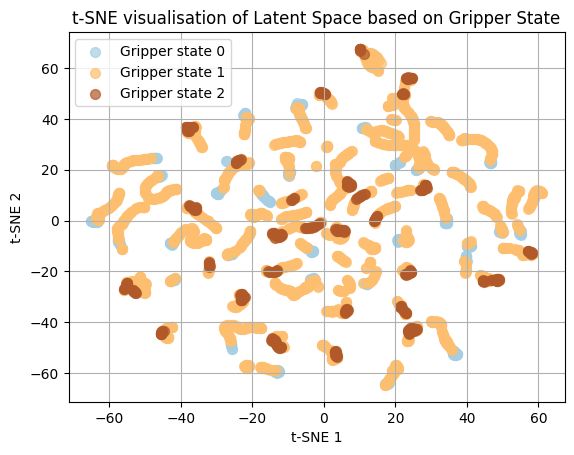

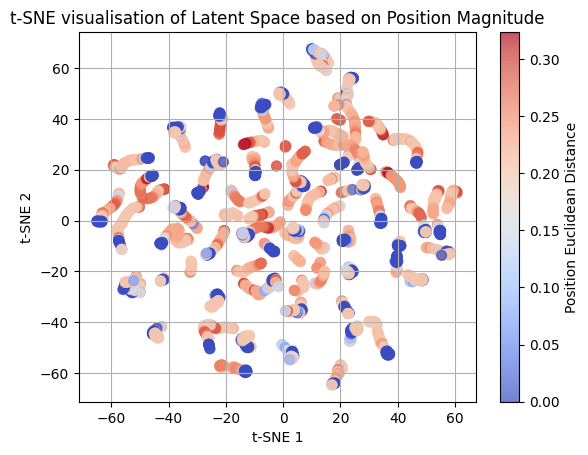

In [165]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_2d_scatters(tsne_points: np.ndarray, positions: np.ndarray, grippers: np.ndarray):
    plt.figure()

    # Based on grippers
    cmap = plt.get_cmap('Paired', np.unique(grippers).size)

    for g in np.unique(grippers):
        indices = np.where(grippers == g)
        g = int(g)
        plt.scatter(
            tsne_points[0, indices], 
            tsne_points[1, indices], 
            color=cmap(g),
            s=50, 
            alpha=0.7, 
            # edgecolors="k",
            label=f'Gripper state {g}'
        )

    plt.title('t-SNE visualisation of Latent Space based on Gripper State')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.grid(True)

    # Based on position
    plt.figure()
    scatter = plt.scatter(tsne_points[0], tsne_points[1], c=positions, cmap="coolwarm", s=50, alpha=0.7)

    plt.colorbar(scatter, label="Position Euclidean Distance")

    plt.title('t-SNE visualisation of Latent Space based on Position Magnitude')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.grid(True)

    plt.show()

best_epoch = 28

ss_vae_weights = torch.load(os.path.join(results_dir, f"vae_{best_epoch}.pt"), weights_only=True)
ss_vae = VAE(latent_dim).to(device)
ss_vae.load_state_dict(ss_vae_weights)

for i, batch in enumerate(val_dataloader):
    img = batch.input["images"]
    obs = batch.input["obs"]
    pos = batch.output["pos"]
    grp = batch.output["grp"]

    if i == 0:
        images = img
        observations = obs
        positions = pos
        grippers = grp
    else:
        images = torch.cat((images, img))
        observations = torch.cat((observations, obs))
        positions = torch.cat((positions, pos))
        grippers = torch.cat((grippers, grp))

ss_vae.eval()
with torch.no_grad():
    images = images.to(device)
    observations = observations.to(device)
    mu, logvar = ss_vae.encode(images, observations)
    z = (ss_vae.reparameterize(mu, logvar)).cpu().detach().numpy()


positions = positions.cpu().detach().numpy()
grippers = grippers.cpu().detach().numpy()

positions = np.linalg.norm(positions, axis=1) # To aggregate three position information into a single magnitude information.
grippers = np.argmax(grippers, axis=1) # To transform from one-hot to class indices


tsne = TSNE(n_components=2, perplexity=30, random_state=1)
tsne_points = tsne.fit_transform(z)
tsne_points = tsne_points.T

plot_2d_scatters(tsne_points, positions, grippers)

### Question 3 Full model training
This question requires you to first develop a supervised head which utilises the latent space from your self-supervised method. You are then required to assess the models performance as well as the model you developed in question 1.c.i on the test set, report the performance and conclude whether self-supervised learning is appropriate for this task.

### Question 3.a Combining self-supervised model with the downstream task (5 marks)

##### Task
- Develop a model which combines the self-supervised pretraining with a model for performing the downstream task by freezing the self-supervised model and fine-tuning a head for prediction and implement it in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions). The supervised head should at least include any inputs that you did not feed into the self-supervised model. For example, assume you decide to perform self-supervised learning only using front_cam_ob images. You must also include mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob observations in your model.

In [176]:
# ******* INSERT YOUR CODE HERE *******
class SSClassifier(BaseModel):
    def __init__(self, vae: VAE):
        super(SSClassifier, self).__init__()

        self.vae = vae
        self.supervised_head = MLP(
            input_dim=latent_dim,
            hidden_dims=[128, 64],
            output_dim=6,
            actvton=nn.ReLU(),    
        )

    def forward(self, images, obs):
        # Freeze the VAE
        with torch.no_grad():
            mu, logvar = self.vae.encode(images, obs)
            z = self.vae.reparameterize(mu, logvar)
        
        z = self.supervised_head(z)

        pos = z[:, :3]
        grp = z[:, 3:]

        return {
            "pos": pos,
            "grp": grp
        }
    
    def reset(self, supervised_head_kwargs):
        self.supervised_head.reset(**supervised_head_kwargs)

def get_dataset(train: bool, transforms: dict) -> NpDictDataset:
    """
    Get the dataset.

    Args:
        train (bool): Whether to get the training dataset.
        transforms (dict): The transforms dictionary.

    Returns:
        NpDictDataset: The dataset.

    """

    if train:
        dataset = NpDictDataset(
            array_dict={k: train_nps[k].astype(np.float32) for k in train_nps},
            transform_lkp=transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
            target_offset=exp_kwargs["target_offset"]
        )

    else:
        dataset = NpDictDataset(
            array_dict={k: val_nps[k].astype(np.float32) for k in val_nps},
            transform_lkp=transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
            target_offset=exp_kwargs["target_offset"]
        )

    return dataset

def get_dataloader(dataset: NpDictDataset, shuffle: bool, batch_size: int) -> DataLoader:
    """
    Get the dataloader.

    Args:
        dataset (NpDictDataset): The dataset.
        shuffle (bool): Whether to shuffle the dataset.
        batch_size (int): The batch size.

    Returns:
        DataLoader: The dataloader.

    """

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_func,
    )

# Strictly restrict images to be between 0 and 1
standardise_normalise_transforms = {
    "front_cam_ob":
        transforms.Compose([
            transforms.ToTensor(),
            lambda x: x / 255.0,
            transforms.Normalize(mean=features_stats["front_cam_ob"]["mean"], std=features_stats["front_cam_ob"]["std"]),
            lambda x: (x - x.min()) / (x.max() - x.min()) # Ensure within 0 and 1
            ]),
    "mount_cam_ob": transforms.Compose([
            transforms.ToTensor(),
            lambda x: x / 255.0,
            transforms.Normalize(mean=features_stats["mount_cam_ob"]["mean"], std=features_stats["mount_cam_ob"]["std"]),
            lambda x: (x - x.min()) / (x.max() - x.min()) # Ensure within 0 and 1
            ]),
    "actions": lambda x: torch.tensor(x),
    "ee_cartesian_pos_ob": lambda x: standardise_data(torch.tensor(x), features_stats, "ee_cartesian_pos_ob"),
    "ee_cartesian_vel_ob": lambda x: standardise_data(torch.tensor(x), features_stats, "ee_cartesian_vel_ob"),
    "joint_pos_ob": lambda x: standardise_data(torch.tensor(x), features_stats, "joint_pos_ob")
}

# Hyperparameters
wandb_name = "Self-Supervised_Classifier"
wandb_grp="Self-Supervised_Classifier"

output_dim = 6

exp_kwargs = {
    "target_offset": 0,
    "half_precision": False,
    "batch_size": 64,
    "learning_rate": 0.0001,
    "preprocessing": "Standardisation",
    "architecture": "SSClassifier"
}

torch.manual_seed(1)

# Load the VAE
ss_vae_state_dict_file = "./results/ss_vae/vae_28.pt"
ss_vae = VAE(latent_dim).to(device)
ss_vae.load_state_dict(torch.load(ss_vae_state_dict_file, weights_only=True))

# Prepare the SSClassifier
ss_classifier = SSClassifier(ss_vae).to(device)
summary(ss_classifier)

optimizer = torch.optim.Adam(ss_classifier.parameters(), lr=exp_kwargs["learning_rate"])

exp_kwargs["optimiser"] = optimizer.__class__.__name__

ss_classifier.reset({})

mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
)

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
)

train_dataset = get_dataset(train=True, transforms=standardise_normalise_transforms)

val_dataset = get_dataset(train=False, transforms=standardise_normalise_transforms)

train_dataloader = get_dataloader(train_dataset, shuffle=True, batch_size=exp_kwargs["batch_size"])
val_dataloader = get_dataloader(val_dataset, shuffle=False, batch_size=exp_kwargs["batch_size"])

output_dir = "./preds/ss_classifier/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
sl_trainer = TorchTrainingLoop(
    model=ss_classifier, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    preds_save_type="csv",
    output_dir=output_dir
)

orig = datetime.datetime.now()

sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "supervised_head_kwargs": {}
    },
    )

post_train = datetime.datetime.now()
# ******* INSERT YOUR CODE HERE - END *******

Layer (type:depth-idx)                   Param #
├─VAE: 1-1                               --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  152
|    |    └─ReLU: 3-2                    --
|    |    └─BatchNorm2d: 3-3             16
|    |    └─Conv2d: 3-4                  1,168
|    |    └─ReLU: 3-5                    --
|    |    └─BatchNorm2d: 3-6             32
|    |    └─Conv2d: 3-7                  4,640
|    |    └─ReLU: 3-8                    --
|    |    └─BatchNorm2d: 3-9             64
|    |    └─Flatten: 3-10                --
|    |    └─Linear: 3-11                 1,605,696
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-12                 512
|    |    └─ReLU: 3-13                   --
|    |    └─Linear: 3-14                 2,112
|    |    └─ReLU: 3-15                   --
|    └─Linear: 2-3                       33,024
|    └─Linear: 2-4                       33,024
|    └─Linear: 2-5                       32,8

100%|██████████| 398/398 [00:41<00:00,  9.52it/s]


epoch_train_loss,█▆▅▄▃▃▂▂▁▁
epoch_val_loss,█▄▂▂▂▁▁▃▄▅
grp_train_loss,█▇▄▄▄▆▄▃▂▃▃▃▃▅▄▃▃▃▂▂▃▂▂▂▂▅▄▂▃▄▃▂▂▃▂▂▂▁▂▂
grp_val_loss,▄▅▄▃▃▃▅▅▆▆▃▄▆▂▅▂▂▆▅▅▃▄▄▃▅▃▃▃▁▂▇▇▅▃▃▃▅▅█▄
min_train_loss,█▆▅▄▃▃▂▂▁▁
min_val_loss,█▄▂▂▂▁▁▁▁▁
pos_train_loss,█▆▇▇▄▅▅▃▄▄▄▂▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁▁▁▁
pos_val_loss,▅▃█▆▅▄▂▂▃▄▂▃▃▃▃▂▃▂▃▂▃▆▂▄▁▁▅▂▄▁▂▁▃▂▃▁▁▁▁▁
epoch_train_loss,0.48062
epoch_val_loss,0.72823
grp_train_loss,0.30121


### Question 3.b Assessing the suitability of self-supervised learning 
For the final two questions, you are required to assess the performance of the self-supervised + supervised head model and the end-to-end model that you have trained. Additionally, you are required to holistically evaluate whether self-supervised learning has been beneficial for this task.

#### Question 3.b.i Assessing the suitability of self-supervised learning (4 marks) 

##### Task
- In the code block below, evaluate the performance of the model you trained in question 3.a and the model you trained in question 1.c.i, using the test set. Additionally use the same metrics to train and evaluate the model that you used for question 1.c.i. Markers should be able to run the cell such that both models are run on the appropriate dataset. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


Data prepared.


wandb: Downloading large artifact End_to_end.Tuned-mdl_chkpnt_epoch_5.pt:v0, 75.27MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


Layer (type:depth-idx)                   Param #
├─JointCNNEncoder: 1-1                   --
|    └─CNN: 2-1                          --
|    |    └─ModuleList: 3-1              5,960
|    └─MLP: 2-2                          --
|    |    └─ModuleList: 3-2              6,455,680
|    └─Flatten: 2-3                      --
├─MLP: 1-2                               --
|    └─ModuleList: 2-4                   --
|    |    └─DenseBlock: 3-3              4,096
|    |    └─DenseBlock: 3-4              65,792
|    |    └─Linear: 3-5                  32,896
├─MLP: 1-3                               --
|    └─ModuleList: 2-5                   --
|    |    └─DenseBlock: 3-6              8,256
|    |    └─DenseBlock: 3-7              2,080
|    |    └─Linear: 3-8                  198
Total params: 6,574,958
Trainable params: 6,574,958
Non-trainable params: 0


wandb:   1 of 1 files downloaded.  


Layer (type:depth-idx)                   Param #
├─VAE: 1-1                               --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  152
|    |    └─ReLU: 3-2                    --
|    |    └─BatchNorm2d: 3-3             16
|    |    └─Conv2d: 3-4                  1,168
|    |    └─ReLU: 3-5                    --
|    |    └─BatchNorm2d: 3-6             32
|    |    └─Conv2d: 3-7                  4,640
|    |    └─ReLU: 3-8                    --
|    |    └─BatchNorm2d: 3-9             64
|    |    └─Flatten: 3-10                --
|    |    └─Linear: 3-11                 1,605,696
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-12                 512
|    |    └─ReLU: 3-13                   --
|    |    └─Linear: 3-14                 2,112
|    |    └─ReLU: 3-15                   --
|    └─Linear: 2-3                       33,024
|    └─Linear: 2-4                       33,024
|    └─Linear: 2-5                       32,8

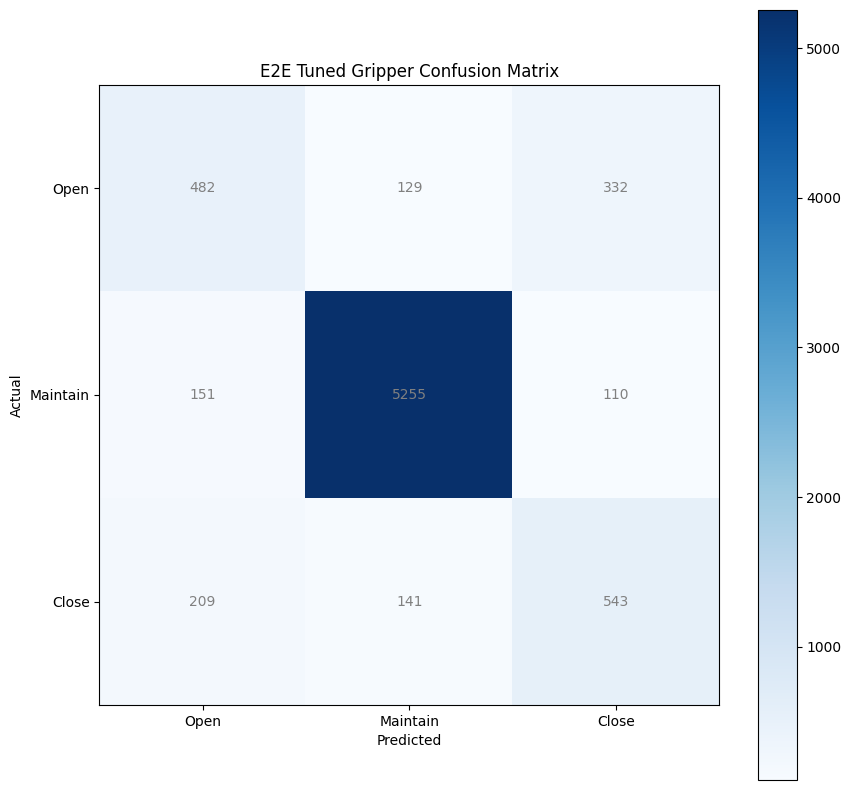

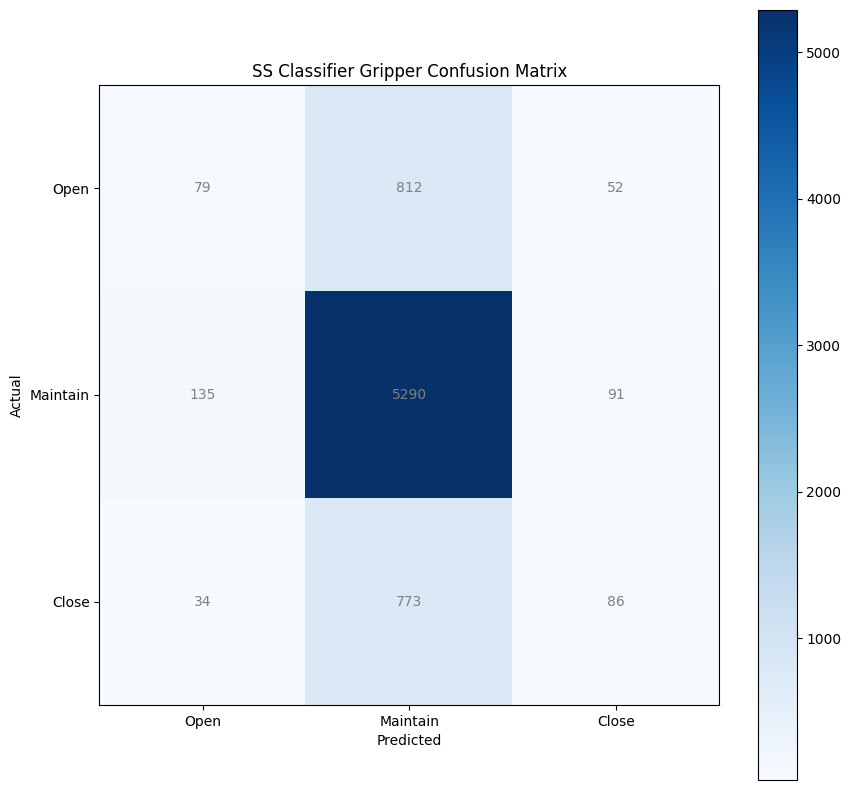

In [ ]:
# ******* INSERT YOUR CODE HERE *******
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from torch.nn import MSELoss, CrossEntropyLoss

test_nps = load_all_files(test_dh.loc,"test_[0-9]+.h5",keys=_keys)
torch.manual_seed(1)
np.random.seed(1)

def get_test_dataset(transforms: dict) -> NpDictDataset:
    """
    Get the test dataset.

    Args:
        transforms (dict): The transforms dictionary.

    Returns:
        NpDictDataset: The test dataset.

    """

    dataset = NpDictDataset(
        array_dict={k: test_nps[k].astype(np.float32) for k in test_nps},
        transform_lkp=transforms,
        dep_vars=["actions"],
        indep_vars=[
            "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
        ],
        target_offset=exp_kwargs["target_offset"]
    )

    return dataset

def get_full_test_dataloader(dataset: NpDictDataset) -> DataLoader:
    """
    Get the full test dataloader.

    Args:
        dataset (NpDictDataset): The test dataset.

    Returns:
        DataLoader: The test dataloader.

    """

    return DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=collate_func,
    )

def create_image_encoder(activation: nn.Module, dropout: float) -> JointCNNEncoder:
    return JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128,
        actvton=activation,
        dropouts=[dropout]
        )
)

def create_obs_encoder(activation: nn.Module, dropout: float) -> MLP:
    return MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128,
    actvton=activation,
    dropouts=[dropout, dropout]
)

def create_dense(activation: nn.Module, dropout: float) -> MLP:
    return MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6,
    actvton=activation,
    dropouts=[dropout, 0]
)

def predict_and_save(location: str, model: BaseModel, dataloader: DataLoader):
    """
    Predict and save the results.

    Args:
        location (str): The location to save the results.
        model (BaseModel): The model to predict.
        dataloader (DataLoader): The dataloader to predict.

    """

    pos_preds = []
    grp_preds = []
    pos_result_filename = "pos_reds.csv"
    grp_result_filename = "grp_reds.csv"

    for i, batch in enumerate(dataloader):
        img = batch.input["images"].to(device)
        obs = batch.input["obs"].to(device)

        with torch.no_grad():
            res = model(img, obs)

        pos = res["pos"].cpu().detach().numpy()
        grp = res["grp"].cpu().detach().numpy()

        pos_preds.append(pos)
        grp_preds.append(grp)

    pos_preds = np.concatenate(pos_preds)
    grp_preds = np.concatenate(grp_preds)
    print(pos_preds.shape)
    print(grp_preds.shape)

    np.savetxt(os.path.join(location, pos_result_filename), pos_preds, delimiter=",")
    np.savetxt(os.path.join(location, grp_result_filename), grp_preds, delimiter=",")
    print("Results saved.")

# Load datasets
e2e_tuned_dataset = get_test_dataset(global_transforms)
ss_classifier_dataset = get_test_dataset(standardise_normalise_transforms) # Normalise between 0 and 1 for images at last step

e2e_tuned_dataset_loader = get_full_test_dataloader(e2e_tuned_dataset)
ss_classifier_dataset_loader = get_full_test_dataloader(ss_classifier_dataset)

print("Data prepared.")

# Load the E2E tuned model
api = wandb.Api()
checkpoint_path = "./results/e2e_tuned/"
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
artifact = api.artifact("lifeng-qiu-lin-ucl/COMP0188_CW2/End_to_end.Tuned-mdl_chkpnt_epoch_5.pt:v0")
artifact.download(root=checkpoint_path)
e2e_tuned_model = Baseline1(
    image_encoder=create_image_encoder(nn.ReLU(), 0.4),
    obs_encoder=create_obs_encoder(nn.ReLU(), 0.4),
    dense=create_dense(nn.ReLU(), 0.4)
)
e2e_tuned_model.load_state_dict(torch.load(os.path.join(checkpoint_path, "mdl_chkpnt_epoch_5.pt"), weights_only=False)["model_state_dict"])
summary(e2e_tuned_model)

# Load the SS Classifier model
checkpoint_path = "./results/ss_classifier/"
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
artifact = api.artifact("lifeng-qiu-lin-ucl/COMP0188_CW2/Self-Supervised_Classifier-mdl_chkpnt_epoch_7.pt:v0")
artifact.download(root=checkpoint_path)
ss_classifier_model = SSClassifier(VAE(latent_dim))
ss_classifier_model.load_state_dict(torch.load(os.path.join(checkpoint_path, "mdl_chkpnt_epoch_7.pt"), weights_only=False)["model_state_dict"])
summary(ss_classifier_model)

print("Models loaded.")


e2e_tuned_pred_dir = "./preds/e2e_tuned_test/"
if not os.path.exists(e2e_tuned_pred_dir):
    os.makedirs(e2e_tuned_pred_dir)

ss_classifier_pred_dir = "./preds/ss_classifier_test/"
if not os.path.exists(ss_classifier_pred_dir):
    os.makedirs(ss_classifier_pred_dir)

# E2E tuned model
e2e_tuned_model.eval()
e2e_tuned_model = e2e_tuned_model.to(device)

# SS Classifier model
ss_classifier_model.eval()
ss_classifier_model = ss_classifier_model.to(device)

predict_and_save(e2e_tuned_pred_dir, e2e_tuned_model, e2e_tuned_dataset_loader)
predict_and_save(ss_classifier_pred_dir, ss_classifier_model, ss_classifier_dataset_loader)

# Load predictions
pos_labels = test_nps["actions"][:, :3]
grp_labels = test_nps["actions"][:, 3:].astype(int)
grp_probs = np.zeros((grp_labels.shape[0], 3))
grp_probs[np.arange(grp_labels.shape[0]), grp_labels] = 1

e2e_tuned_pos_preds = np.loadtxt(os.path.join(e2e_tuned_pred_dir, "pos_reds.csv"), delimiter=",")
e2e_tuned_grp_preds_prob = np.loadtxt(os.path.join(e2e_tuned_pred_dir, "grp_reds.csv"), delimiter=",")
e2e_tuned_grp_preds = np.argmax(e2e_tuned_grp_preds_prob, axis=1)

ss_classifier_pos_preds = np.loadtxt(os.path.join(ss_classifier_pred_dir, "pos_reds.csv"), delimiter=",")
ss_classifier_grp_preds_prob = np.loadtxt(os.path.join(ss_classifier_pred_dir, "grp_reds.csv"), delimiter=",")
ss_classifier_grp_preds = np.argmax(ss_classifier_grp_preds_prob, axis=1)

print("Predictions loaded.")

# Metrics
torch_mse = MSELoss()
torch_cross_entropy = CrossEntropyLoss()

e2e_tuned_metrics = {
    "pos_mse": torch_mse(torch.tensor(pos_labels), torch.tensor(e2e_tuned_pos_preds)).item(),
    "pos_rmse": np.sqrt(torch_mse(torch.tensor(pos_labels), torch.tensor(e2e_tuned_pos_preds)).item()),
    "grp_ce": torch_cross_entropy(torch.tensor(e2e_tuned_grp_preds_prob), torch.tensor(grp_probs)).item(),
    "grp_cm": confusion_matrix(grp_labels, e2e_tuned_grp_preds),
    "grp_report": classification_report(grp_labels, e2e_tuned_grp_preds),
}
e2e_tuned_metrics["total_loss"] = e2e_tuned_metrics["pos_mse"] + e2e_tuned_metrics["grp_ce"]

ss_classifier_metrics = {
    "pos_mse": torch_mse(torch.tensor(pos_labels), torch.tensor(ss_classifier_pos_preds)).item(),
    "pos_rmse": np.sqrt(torch_mse(torch.tensor(pos_labels), torch.tensor(ss_classifier_pos_preds)).item()),
    "grp_ce": torch_cross_entropy(torch.tensor(ss_classifier_grp_preds_prob), torch.tensor(grp_probs)).item(),
    "grp_cm": confusion_matrix(grp_labels, ss_classifier_grp_preds),
    "grp_report": classification_report(grp_labels, ss_classifier_grp_preds),
}
ss_classifier_metrics["total_loss"] = ss_classifier_metrics["pos_mse"] + ss_classifier_metrics["grp_ce"]


print("Metrics calculated.")

print("Presenting results: ")

print(f"""

E2E Tuned Model:
- Total Loss: {e2e_tuned_metrics["total_loss"]:.4f}
- Position MSE: {e2e_tuned_metrics["pos_mse"]:.4f}
- Position RMSE: {e2e_tuned_metrics["pos_rmse"]:.4f}
- Gripper Cross Entropy: {e2e_tuned_metrics["grp_ce"]:.4f}
- Gripper Confusion Matrix:
{e2e_tuned_metrics["grp_cm"]}
- Gripper Classification Report:
{e2e_tuned_metrics["grp_report"]}

SS Classifier Model:
- Total Loss: {ss_classifier_metrics["total_loss"]:.4f}
- Position MSE: {ss_classifier_metrics["pos_mse"]:.4f}
- Position RMSE: {ss_classifier_metrics["pos_rmse"]:.4f}
- Gripper Cross Entropy: {ss_classifier_metrics["grp_ce"]:.4f}
- Gripper Confusion Matrix:
{ss_classifier_metrics["grp_cm"]}
- Gripper Classification Report:
{ss_classifier_metrics["grp_report"]}
""")

plt.figure(figsize=(10, 10))
plt.imshow(e2e_tuned_metrics["grp_cm"], cmap="Blues")
plt.title("E2E Tuned Gripper Confusion Matrix")
plt.xticks(range(3), ["Open", "Maintain", "Close"])
plt.yticks(range(3), ["Open", "Maintain", "Close"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
for i in range(3):
    for j in range(3):
        plt.text(j, i, e2e_tuned_metrics["grp_cm"][i, j], ha="center", va="center", color="gray")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(ss_classifier_metrics["grp_cm"], cmap="Blues")
plt.title("SS Classifier Gripper Confusion Matrix")
plt.xticks(range(3), ["Open", "Maintain", "Close"])
plt.yticks(range(3), ["Open", "Maintain", "Close"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
for i in range(3):
    for j in range(3):
        plt.text(j, i, ss_classifier_metrics["grp_cm"][i, j], ha="center", va="center", color="gray")
plt.show()

# ******* INSERT YOUR CODE HERE - END *******

#### Question 3.b.ii Justification (5 marks)

##### Task
- Conclude whether the self-supervised pre-training was beneficial for the task of predicting actions. Your answer should not solely focus on final performance but rather be nuianced and balance other model development considerations for example parameter count and speed of convergence. Also, if you believe the comparison between the model trained in question 3.a.i aganst the model trained in question 2.c.i is not _fair_, discuss further experiments which you would perform to reduce the bias in your conclusions. Provide __empirical evidence__ to support your conclusions. __0 marks__ will be awarded if empirical evidence is __not__ provided.

##### Answer

Testing both the End-to-End (E2E) Tuned model and the Self-Supervised (SS) Classifier model on the test dataset yielded the following results:

| Metric                  | E2E Tuned Model | SS Classifier Model |
|-------------------------|-----------------|---------------------|
| Total Loss              | 9.4901          | 5.7936              |
| Position MSE            | 0.0081          | 0.0279              |
| Position RMSE           | 0.0899          | 0.1670              |
| Gripper Cross Entropy   | 9.4821          | 5.7657              |
| Accuracy                | 0.85            | 0.74                |
| Weighted F1-Score       | 0.85            | 0.68                |
| Open Recall             | 0.51            | 0.08                |
| Close Recall            | 0.61            | 0.09                |

The table indicates that, despite the SS Classifier's lower total loss, the E2E Tuned Model delivers better results overall. This discrepancy arises because the SS Classifier's lower loss is predominantly in the gripper cross entropy component, yet tangible metrics favour the E2E approach.

- **Position Losses:** The E2E Tuned Model predicts position more accurately, with noticeable RMSE improvements from 0.1670 to 0.0899.
  
- **Gripper Performance:** Despite the lower gripper cross entropy loss, the SS Classifier underperforms in other critical metrics. Notably, the weighted F1-score for the E2E Model is significantly higher (from 0.68 to 0.85). The SS Classifier's inadequate recall for open and close states suggests an inability to reliably execute tasks requiring gripper state changes. Conversely, the E2E Model accurately predicts necessary state changes in over half of these opportunities.

- **Confusion Matrix Comparison:** The E2E Model exhibits a stronger diagonal in confusion matrices, underlining its superior proficiency in classification:

  ![End-to-End Tuned Test Confusion Matrix](./img/e2e_tuned.test_cm.png)
  ![Self-Supervised Classifier Test Confusion Matrix](./img/ss_classifier.test_cm.png)

- **Convergence Analysis:** The following plot contrasts the convergence of both models on the validation set across epochs. While the SS Classifier stabilizes earlier, it barely reduces loss during training:

  ![End-to-End Tuned vs Self-Supervised Classifier Epoch Losses](./img/e2e_tuned_vs_ss_classifier.epoch_losses.png)

- **Parameter Count and Training Duration:** The E2E Model has approximately 6.5 million parameters, while the SS Classifier has 5 million. Training times were 6m31s for the E2E model and 24m17s for the VAE, with an additional 8m41s for the SS Classifier head.

Considering these durations, the utility of the self-supervised model appears limited in this context. However, self-supervised learning is advantageous when large annotated datasets are unavailable, and well-performing pre-trained models expedite adaptation for other tasks. End-to-End models necessitate training from scratch, insight gathering, and longer experimental stages.

It is essential to acknowledge that the SS Classifier faced experimental disadvantages in this coursework compared to E2E. For example, more experiments could have investigated which features are more suited for self-supervised learning, as images are often more informative than numerical observations. Although architectural tuning and hyperparameter experiments were conducted for the SS approach, further exploration with additional time and resources could yield valuable improvements.

In conclusion, while self-supervised pre-training holds substantial potential, it did not surpass the End-to-End Tuned Model in this specific assessment, but its adaptability and efficiency in data-scarce environments should not be underestimated.